### Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
drive_dir = '/content/drive/MyDrive/AIF/'
file_path = 'Dataset_2.0_Akkodis_final.xlsx'
processed_file_path = 'Dataset_2.0_Akkodis_final_processed.xlsx'
best_models_dict = 'best_models.pkl'
best_params_nn_dict = "best_nn_params.pkl"

### Install requirements

In [3]:
source_path = drive_dir + 'requirements.txt'
!pip install -r {source_path}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 

### Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.base
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, StratifiedKFold, RandomizedSearchCV, PredefinedSplit
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

from scipy.stats import chi2_contingency

from lime import lime_tabular
import shap

import re
import time
import pickle

from ctgan import CTGAN

random_seed = 42
random_state = 42

###Utils

#####Visualization

In [7]:
def getPie(df, feature, mapping):
  distribution = df[feature].value_counts(normalize=True)
  plt.figure(figsize=(8, 6))
  labels = [mapping[feature][i] for i in distribution.index]
  plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
  plt.rcParams.update({'font.size': 10})
  plt.title(f'Distribution of {feature}')
  plt.show()

In [8]:
def plot_category_distributions(df, group_col, target_col, encoding_mappings, reverse_mapping):
    group_values = encoding_mappings[group_col]

    distribs = {}
    for group_key, encoded_value in group_values.items():
        distrib = df[df[group_col] == encoded_value][target_col].value_counts(normalize=True)
        if not distrib.empty:
            distribs[group_key] = distrib

    num_subplots = len(distribs)
    rows = num_subplots // 3 + (num_subplots % 3 > 0)
    cols = min(num_subplots, 3)
    plt.figure(figsize=(num_subplots * 5, num_subplots * 5))
    plt.rcParams.update({'font.size': 4*num_subplots})
    for i, (group_label, distribution) in enumerate(distribs.items()):
        plt.subplot(rows, cols, i + 1)

        labels = [reverse_mapping[target_col][idx] for idx in distribution.index]

        plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f'{target_col} distrib for {group_label} as {group_col.replace("_encoded", "")}')

    plt.tight_layout()
    plt.show()


In [9]:
def plot_bar_norm(data_set, feature, target, encoding_mappings, reverse_mapping):
    plt.rcParams.update({'font.size': 10})
    pivot = data_set.pivot_table(index=feature, columns=target, aggfunc='size', fill_value=0)
    pivot.rename(columns=reverse_mapping[target], inplace=True)
    pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

    ax = pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

    if feature in encoding_mappings.keys():
        ax.set_xticklabels(encoding_mappings[feature].keys())

    plt.title(f'{target} by {feature} (Normalized)')
    plt.ylabel('Proportion')
    plt.xlabel(feature)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


#####shap explanations

In [6]:
def create_explanations(model, X, name):
    if name.startswith('Neural Network'):
        background_data = shap.sample(X, 10)
        def predict_proba(X):
            return tf.keras.activations.sigmoid(model.predict(X)).numpy()
        explainer = shap.KernelExplainer(predict_proba, background_data)
        shap_values = explainer.shap_values(X.values[:10])
        shap_values = np.squeeze(shap_values)
        print("shap shape:", shap_values.shape)
        return shap_values, X[:10]

    explainer = shap.Explainer(model, X)
    explanations = explainer(X)
    return explanations, X

def summaryPlot(model, X, lf, plot_type, plot_name):
    explanations, X = create_explanations(model, X, plot_name)

    fig, ax = plt.subplots()
    plt.title(f"{plot_name}")
    shap.summary_plot(explanations, X, lf, show=False, plot_size=None, plot_type=plot_type, max_display=len(lf), sort=True)
    plt.tight_layout()
    plt.show()
    plt.close()

#####training

In [10]:
def reweight_dataset(X_train, y_train, sensitive_features, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    group_counts = X_train.groupby(sensitive_features).size()
    group_weights = 1 / group_counts
    group_weights /= group_weights.sum()

    sample_weights = X_train[sensitive_features].apply(tuple, axis=1).map(group_weights)

    sample_weights /= sample_weights.sum()

    reweighted_indices = np.random.choice(
        X_train.index,
        size=len(X_train),
        replace=True,
        p=sample_weights)
    X_train_reweighted = X_train.loc[reweighted_indices]
    y_train_reweighted = y_train.loc[reweighted_indices]

    return X_train_reweighted, y_train_reweighted


In [11]:
def fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions):
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if name in ['Linear Regression', 'XGBoost']:
        y_proba = y_pred
        y_pred = (y_proba > 0.5).astype(int)
    elif hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred

    predictions[name] = y_pred

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_proba), 3)

    if sum(y_pred) == 0:
        print(f"Warning: No positive predictions for {name}. Precision and Recall may be ill-defined.")

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

In [22]:
def create_model(X_train, neurons=64, optimizer='adam', learning_rate = None, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(len(X_train.columns),)))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    #neurons = neurons // 2
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    neurons = neurons // 2
    model.add(Dense(neurons, activation=activation,))
    model.add(BatchNormalization())
    model.add(Dense(1))

    if isinstance(optimizer, str):
        if optimizer == 'adam':
            optimizer = Adam
        elif optimizer == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop
        elif optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")


    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [75]:
#new
def fit_nn(name, seed, neural_models, histories, X_train, y_train, X_validation, y_validation, X_test, neural_predictions, best_params, early_stopping=None):

    print(f"Fitting model {name}...")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = CustomKerasClassifier(input_shape=(X_train.shape[1],), neurons = best_params['neurons'], optimizer = best_params['optimizer'], learning_rate = best_params['learning_rate'], activation = best_params['activation'] )
    neural_models.append(model)

    model.fit(X_train, y_train, validation_data=(X_validation, y_validation), early_stopping=early_stopping)
    history = model.get_history()
    histories.append(history)
    print(f"Model {name} fitted.\n")


In [14]:
def predict_nn(name, model, X_test, neural_predictions):
    print(f"Predicting with model {name}...")
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    neural_predictions.append(y_pred)
    print(f"Predictions from model {name} stored.\n\n")

In [15]:
def plot_val_train(h, name):
  metrics = ['loss','accuracy','auc','recall','precision']
  metric_keys = []
  count = 0
  for m in metrics:
    key = re.compile(re.escape(m))
    if any(key.search(k) for k in list(h.keys())):
      count += 1
      keys = [k for k in h.keys() if key.search(k)]
      metric_keys.append(keys)

  if count == 0:
    return

  plt.figure(figsize=(12, 6))

  for i in range(count):
    plt.subplot(1, count, i+1)
    plt.plot(h[metric_keys[i][0]])
    plt.plot(h[metric_keys[i][1]])
    plt.title(f'{name} {metrics[i]}')
    plt.ylabel(metrics[i])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

In [16]:
def calc_nn_metrics(y_pred, y_test, nn_metrics, name):
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
  recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
  f1 = round(f1_score(y_test, y_pred), 3)
  roc_auc = round(roc_auc_score(y_test, y_pred), 3)

  nn_metrics.append({
      'Model': name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1,
      'ROC AUC': roc_auc
  })

#####fairness metrics

In [17]:
def calculate_demographic_parity(predictions, y_test, name, significance_level, tolerance, X_test, activate_check=False, model = None):

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    positive_proportions = df.groupby('sensitive_attribute')['predictions'].mean()
    num_class = positive_proportions.shape[0]
    min_proportion = positive_proportions.min()
    max_proportion = positive_proportions.max()
    percentage_difference = (max_proportion - min_proportion)
    discr_gr = reverse_mapping[name][positive_proportions.index[positive_proportions.values.argmin()]]

    if num_class == 2:

        if activate_check == True and percentage_difference > tolerance:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            print(f"{reverse_mapping[name][0]}: {positive_proportions[0]}")
            print(f"{reverse_mapping[name][1]}: {positive_proportions[1]}")
            print(f"Model unfair to: {discr_gr}")
            print("=====================================================================\n\n")
        if percentage_difference <= tolerance:
            return True
        else:
            return discr_gr

    if num_class > 2:
        contingency_table = pd.crosstab(df['predictions'], df['sensitive_attribute'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        if activate_check == True and p <= significance_level:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            if (expected < 5).any():
                print(f"Sparse contigency for {name}")
            else:
              for i in range(len(positive_proportions)):
                print(f"{reverse_mapping[name][i]}: {positive_proportions[i]}")
              print(f"Model unfair to: {discr_gr}")

            print("=====================================================================\n\n")
        if p > significance_level:
            return True
        else:
            return discr_gr

In [18]:
def calculate_equalized_odds(predictions, true_labels, name, significance_level, tolerance, X_test, activate_check=False, model = None):
    df = pd.DataFrame({
        'predictions': predictions,
        'true_labels': true_labels,
        'sensitive_attribute': X_test[name]
    })

    groups = df['sensitive_attribute'].unique()
    metrics = {}
    for group in groups:
        group_df = df[df['sensitive_attribute'] == group]
        cm = confusion_matrix(group_df['true_labels'], group_df['predictions'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        if tp + fn == 0:
            print(f"\n\nThere are no positive examples for the group {reverse_mapping[name][group]} in the test set")
        if fp + tn == 0:
            print(f"\n\nThere are no negative examples for the group{reverse_mapping[name]} {group} in the test set")
        tpr = tp / (tp + fn) if tp + fn != 0 else 0
        fpr = fp / (fp + tn) if fp + tn != 0 else 0
        metrics[group] = {'TPR': tpr, 'FPR': fpr}

    tprs = [metrics[group]['TPR'] for group in groups]
    fprs = [metrics[group]['FPR'] for group in groups]

    max_tpr_diff = max(tprs) - min(tprs)
    max_fpr_diff = max(fprs) - min(fprs)

    tpr_within_tolerance = max_tpr_diff <= tolerance*2
    fpr_within_tolerance = max_fpr_diff <= tolerance*2
    result = tpr_within_tolerance and fpr_within_tolerance
    discr_gr_tpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['TPR'])]
    discr_gr_fpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['FPR'])]
    if activate_check == True and result == False:
        max_tpr_group = max(metrics, key=lambda g: metrics[g]['TPR'])
        min_tpr_group = min(metrics, key=lambda g: metrics[g]['TPR'])
        max_fpr_group = max(metrics, key=lambda g: metrics[g]['FPR'])
        min_fpr_group = min(metrics, key=lambda g: metrics[g]['FPR'])
        print("===============================UNFAIR!===============================")
        print(f"Model {model} unfair wrt {name}")
        if tpr_within_tolerance == False:
            print(f"Maximum TPR difference: {max_tpr_diff:.4f} between group {reverse_mapping[name][max_tpr_group]} and group {reverse_mapping[name][min_tpr_group]}")
            print(f"Model unfair to: {discr_gr_tpr}")
        if fpr_within_tolerance == False:
            print(f"Maximum FPR difference: {max_fpr_diff:.4f} between group {reverse_mapping[name][max_fpr_group]} and group {reverse_mapping[name][min_fpr_group]}")
            print(f"Model unfair to: {discr_gr_fpr}")
        print("TPR and FPR for each group:")
        for group, metric in metrics.items():
            print(f"Group {reverse_mapping[name][group]}: TPR={metric['TPR']:.4f}, FPR={metric['FPR']:.4f}")
        print("=====================================================================\n\n")
    if result == False:
      if tpr_within_tolerance == False and fpr_within_tolerance == False:
        if discr_gr_fpr == discr_gr_tpr:
          return discr_gr_fpr
        else:
          return discr_gr_tpr+' '+discr_gr_fpr
      elif tpr_within_tolerance == False:
        return discr_gr_tpr
      else:
        return discr_gr_fpr
    else:
      return True

In [19]:
def calculate_counterfactual_fairness(predictions, y_test, name, significance_level, tolerance, X_test, model=None, activate_check=False):
    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    counterfactual_df = X_test.copy()
    delta = {}
    consistency = {}

    for group in df['sensitive_attribute'].unique():
        counterfactual_df[name] = group

        if isinstance(model, (tf.keras.Sequential, tf.keras.Model)):
            new_preds = model.predict(counterfactual_df, verbose=0)
        else:
            new_preds = model.predict(counterfactual_df)

        if len(np.unique(new_preds)) > 2:
            new_preds = (new_preds > 0.5).astype(int)

        consistency[group] = 1 - np.mean(np.abs(predictions - new_preds))

        n_old = np.sum(predictions)
        n_new = np.sum(new_preds)
        delta[group] = (n_new - n_old) / len(predictions)

    most_inconsistent_group = min(consistency, key=consistency.get)
    counterfactual_consistency = consistency[most_inconsistent_group]

    most_discriminated_group = min(delta, key=delta.get)
    delta_min = delta[most_discriminated_group]
    most_privileged_group = max(delta, key=delta.get)
    delta_max = delta[most_privileged_group]

    is_fair = (delta_max - delta_min < tolerance) and (counterfactual_consistency >= (1 - tolerance))

    if activate_check:
        if not is_fair:
            print("===============================UNFAIR!===============================")
        else:
            print("=====================================================================")
        print(f"Model {model} unfair wrt Counterfactual Fairness on {name}")
        print(f"Counterfactual consistency: {counterfactual_consistency:.4f}")
        print(f"Most inconsistent group: {reverse_mapping[name][most_inconsistent_group]} {delta[most_inconsistent_group]:.4f}")
        print(f"Most discriminated group: {reverse_mapping[name][most_discriminated_group]} {delta_min:.4f}")
        print(f"Most privileged group: {reverse_mapping[name][most_privileged_group]} {delta_max:.4f}")
        print(f"Direction of bias (negative = worse, positive = better)")
        print("=====================================================================\n\n")

    if not is_fair:
        return reverse_mapping[name][most_discriminated_group], delta_min, reverse_mapping[name][most_privileged_group], delta_max

    return True

In [20]:
def getFairnessTab(fn, models, sensitive_features, predictions, index, X_test, significance_level, tolerance, verbose=False):
    table = []

    for model_name in index:
        temp = []
        for i in range(len(sensitive_features)):
            model_predictions = predictions[model_name]
            output = fn(
                model_predictions,
                y_test,
                sensitive_features[i],
                significance_level,
                tolerance,
                X_test,
                model=models[model_name],
                activate_check=verbose
            )

            if output == True:
                temp.append('')
            else:
                temp.append(output)
        table.append(temp)

    return pd.DataFrame(table, index=index, columns=sensitive_features)


###Classes

In [77]:
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, neurons=10, activation='relu', optimizer='adam', batch_size=32, epochs=20, learning_rate=0.001):
        self.input_shape = input_shape
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        #self._estimator_type = type(KerasClassifier)

    def build_tf_model(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Dense(self.neurons, activation=self.activation),
            BatchNormalization(),
            Dropout(0.4),
            Dense(self.neurons, activation=self.activation),
            BatchNormalization(),
            Dropout(0.4),
            Dense(self.neurons//2, activation=self.activation),
            BatchNormalization(),
            Dense(1)
            #Dense(1, activation='sigmoid')
        ])

        if self.optimizer == 'adam':
            optimizer_fn = Adam
        elif self.optimizer == 'rmsprop':
            optimizer_fn = tf.keras.optimizers.RMSprop
        elif self.optimizer == 'sgd':
            optimizer_fn = tf.keras.optimizers.SGD
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}")


        model.compile(optimizer=optimizer_fn(learning_rate=self.learning_rate),
                      loss= BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        return model

    def fit(self, X, y, validation_data=None, early_stopping=None):
        self.classes_ = np.unique(y)
        self.class_weights = {0: 1, 1: len(y[y == 0]) / len(y[y == 1])}
        self.model = self.build_tf_model()
        if validation_data is not None:
          X_val, y_val = validation_data
          self.history = self.model.fit(X, y, epochs=self.epochs,
                         batch_size=self.batch_size, verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping],
                         class_weight=self.class_weights)
        else:
          self.model.fit(X, y, epochs=self.epochs,
                         batch_size=self.batch_size, verbose=1,
                         class_weight=self.class_weights)
          self.history = None
        return self

    def predict(self, X):
        y_pred_proba = self.model.predict(X)
        return (y_pred_proba > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        y_pred_proba = self.model.predict(X)
        y_pred_proba = sigmoid(y_pred_proba)
        y_pred_proba = y_pred_proba.reshape(-1, 1)
        return np.hstack([1 - y_pred_proba, y_pred_proba])

    def score(self, X, y):
        y_pred_proba = self.predict_proba(X)[:, 1]
        return roc_auc_score(y, y_pred_proba)

    def get_params(self, deep=True):
        return {'input_shape': self.input_shape,
                'neurons': self.neurons,
                'activation': self.activation,
                'optimizer': self.optimizer,
                'batch_size': self.batch_size,
                'epochs': self.epochs,
                'learning_rate': self.learning_rate}

    def get_history(self):
        return self.history


## Dataset Import

In [26]:
df = pd.read_excel(drive_dir + file_path)

print(f"There are {df['Id'].unique().shape[0]} candidates\n")

print(f"Total number of rows: {df.shape[0]}\n")

print(f"HIRED distribution: \n\n{df.groupby('Id')['Hired'].first().value_counts()}\n\n")

df.head()

There are 4705 candidates

Total number of rows: 14115

HIRED distribution: 

Hired
0    4275
1     430
Name: count, dtype: int64




Id Candidate State      Age Range     Sex Protected Category  \
0   165           hired  26 - 30 years    male                 no   
1   369           hired  26 - 30 years  female                 no   
2   423           hired  36 - 40 years    male                 no   
3  1006           hired     > 45 years    male                 no   
4  1038           hired  26 - 30 years    male                 no   

                                                 Tag              Study Area  \
0                               angular, javascript.             informatics   
1                                             matlab  mechanical engineering   
2  blood lines, medical device, medical devices d...             informatics   
3                                      not specified                   other   
4                                      not specified             informatics   

              Study Title Years Experience         Sector  ...  \
0       three-year degree            [1-3]        telecom  ...   
1       three-year degree            [1-3]     automotive  ...   
2  high school graduation            [+10]  life sciences  ...   
3  high school graduation            [+10]         energy  ...   
4  high school graduation            [1-3]     consulting  ...   

  Residence_coord  Assumption_coord Distance (km)  \
0    (None, None)      (None, None)           0.0   
1    (None, None)      (None, None)           0.0   
2    (None, None)      (None, None)           0.0   
3    (None, None)      (None, None)           0.0   
4    (None, None)      (None, None)           0.0   

                                       Position_Info Similarity_Score  \
0  frontend developer tech consulting solutions c...             0.17   
1  powertrain calibration engineer engineering ju...             0.14   
2                             engineering consultant             0.00   
3  rs190865 team procurement milan engineering 1 ...             0.36   
4  hardware, software, networking mostggs support...             0.00   

  Similarity_Score_Study_Area Study_Title_Score Similarity_Score_Last_Role  \
0                        1.00              0.00                        0.0   
1                        0.19             -0.14                        0.0   
2                        0.00              0.00                        0.0   
3                        0.00             -0.14                        0.0   
4                        0.00             -0.29                        0.0   

  Years_Exp_Score Ral_Score  
0            0.00     -0.07  
1            0.07      0.00  
2            0.00      0.00  
3            1.00      0.00  
4           -0.10      0.00  

[5 rows x 51 columns]

In [27]:
#new sensitive column
df['Italian Residence'] = df['Residence Country'].apply(lambda x: 'yes' if x == 'italy' else 'no')

##Data Set
Some columns will be dropped either because they would not be available (i.e. Candidate State) or because of redundancy.

In [33]:
data_set = df.copy()

columns_to_drop = ['Candidate State', 'Tag' , 'Recruitment Request', 'Last Role',
                   'Job Description', 'Candidate Profile', 'Year Of Insertion', 'Year Of Recruitment',
                   'Job Title Hiring', 'Years Experience.1', 'Study Level', 'Study Area.1',
                   'Job ID', 'Residence_coord', 'Assumption_coord', 'Assumption Headquarters',
                   'Candidate_Info', 'Position_Info', 'Akkodis Headquarters', 'Job Family Hiring']

data_set = data_set.drop(columns=columns_to_drop)

for col in data_set.columns:
  print(f"{col}: \n {data_set[col].unique()}")

Id: 
 [  165   369   423 ... 81623 81627 81630]
Age Range: 
 ['26 - 30 years' '36 - 40 years' '> 45 years' '31 - 35 years' '< 20 years'
 '40 - 45 years' '20 - 25 years']
Sex: 
 ['male' 'female']
Protected Category: 
 ['no' 'yes']
Study Area: 
 ['informatics' 'mechanical engineering' 'other' 'biomedical engineering'
 'aeronautical/aerospace/astronautics engineering'
 'other scientific subjects' 'political-social' 'electronic engineering'
 'electrical engineering' 'computer engineering'
 'telecommunications engineering' 'automotive engineering' 'surveyor'
 'automation/mechatronics engineering' 'economic - statistics'
 'other humanities subjects' 'energy and nuclear engineering' 'psychology'
 'chemical engineering' 'information engineering' 'management engineering'
 'chemist - pharmaceutical' 'accounting' 'industrial engineering'
 'communication sciences' 'mathematics' 'literary'
 'civil/civil and environmental engineering'
 'humanistic high school diploma' 'linguistics'
 'agriculture and

##Preprocessing
### Categorical - Numerical mapping

In [34]:
ral_mapping = {
     '-20k': 10,
     '20-22k': 21,
     '22-24k': 23,
     '24-26k': 25,
     '26-28k': 27,
     '28-30k': 29,
     '30-32k': 31,
     '32-34k': 33,
     '34-36k': 35,
     '36-38k': 37,
     '38-40k': 39,
     '40-42k': 41,
     '42-44k': 43,
     '44-46k': 45,
     '46-48k': 47,
     '48-50k': 49,
     '+50k': 70,
     'not specified': 'not specified'
}

for col in data_set.columns:
  if 'Ral' in col and col != 'Ral_Score':
     data_set[col] = data_set[col].map(ral_mapping)

years_exp_mapping = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

data_set['Years Experience'] = data_set['Years Experience'].map(years_exp_mapping)

### Encoding of categorical columns

In [35]:
categorical_columns = ['Sex', 'Age Range', 'Protected Category', 'Study Area', 'Study Title',
                       'Sector', 'Residence Country', 'Residence Italian Region',
                       'European Residence', 'Italian Residence']
numerical_columns = [col for col in data_set.columns if col not in categorical_columns]

In [36]:
encoding_mappings = {}

encoding_mappings['Age Range_encoded'] = {
    '< 20 years': 0,
    '20 - 25 years': 1,
    '26 - 30 years': 2,
    '31 - 35 years': 3,
    '36 - 40 years': 4,
    '40 - 45 years': 5,
    '> 45 years': 6
}

data_set['Age Range_encoded'] = data_set['Age Range'].map(encoding_mappings['Age Range_encoded'])
data_set = data_set.drop(columns='Age Range')

categorical_columns.remove('Age Range')

encoding_mappings['Study Title_encoded'] = {
    'middle school diploma': 0,
    'professional qualification': 1,
    'high school graduation': 2,
    'three-year degree': 3,
    'five-year degree': 4,
    'master\'s degree': 5,
    'doctorate': 6
}

data_set['Study Title_encoded'] = data_set['Study Title'].map(encoding_mappings['Study Title_encoded'])
data_set = data_set.drop(columns='Study Title')

categorical_columns.remove('Study Title')

for col in categorical_columns:
  label_encoder = LabelEncoder()
  data_set[f"{col}_encoded"] = label_encoder.fit_transform(data_set[col])
  encoding_mappings[f"{col}_encoded"] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data_set = data_set.drop(columns=categorical_columns)

encoding_mappings['Hired'] = {'Not Hired': 0, 'Hired': 1}

reverse_mapping = {}

for col, mapping in encoding_mappings.items():
    reverse_mapping[col] = {v: k for k, v in mapping.items()}

###NaN handling

'not specified' values for numerical columns are replaced with the mean value.

In [37]:
not_spec_col = []

for col in data_set.columns:
  if 'not specified' in data_set[col].unique() :
    not_spec_col.append(col)

for col in not_spec_col:
  if col in numerical_columns:
    data_set[col] = pd.to_numeric(data_set[col], errors='coerce')
    mean_val = data_set[col].dropna().mean()
    if pd.isna(mean_val):
      mean_val = 0
    else:
      mean_val = round(mean_val)

    data_set[col] = data_set[col].replace('not specified', mean_val)
    data_set[col] = data_set[col].fillna(mean_val)

for col in not_spec_col:
  print(type(data_set[col][0]))
  print(f"{col}: {data_set[col].unique()}")

<class 'numpy.float64'>
Overall: [3. 2. 4. 1.]
<class 'numpy.float64'>
Minimum Ral: [23. 29. 25. 21. 31. 27. 10. 33. 39. 37. 41. 35. 70.]
<class 'numpy.float64'>
Ral Maximum: [29. 25. 26. 33. 31. 37. 35. 49. 27. 41. 45. 39. 10. 43. 70. 23. 21.]
<class 'numpy.float64'>
Current Ral: [23. 34. 35. 27. 29. 21. 70. 31. 39. 33. 43. 37. 25. 10. 41. 45. 49. 47.]
<class 'numpy.float64'>
Expected Ral: [27. 37. 41. 33. 31. 25. 70. 29. 39. 35. 43. 10. 21. 23. 45. 47. 49.]
<class 'numpy.float64'>
Technical Skills: [2. 3. 1. 4.]
<class 'numpy.float64'>
Standing/Position: [3. 2. 4. 1.]
<class 'numpy.float64'>
Communication: [3. 2. 4. 1.]
<class 'numpy.float64'>
Maturity: [3. 2. 4. 1.]
<class 'numpy.float64'>
Dynamism: [3. 2. 4. 1.]
<class 'numpy.float64'>
Mobility: [1. 2. 3. 4.]
<class 'numpy.float64'>
English: [3. 2. 4. 1.]


### Standardization

In [38]:
for col in numerical_columns:
  print(f"{col}: {np.sort(data_set[col].unique().tolist())}")

Id: [   41    47    84 ... 81623 81627 81630]
Years Experience: [ 0.   0.5  2.   4.   6.   8.5 20. ]
Overall: [1. 2. 3. 4.]
Minimum Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 70.]
Ral Maximum: [10. 21. 23. 25. 26. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 49. 70.]
Current Ral: [10. 21. 23. 25. 27. 29. 31. 33. 34. 35. 37. 39. 41. 43. 45. 47. 49. 70.]
Expected Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49. 70.]
Technical Skills: [1. 2. 3. 4.]
Standing/Position: [1. 2. 3. 4.]
Communication: [1. 2. 3. 4.]
Maturity: [1. 2. 3. 4.]
Dynamism: [1. 2. 3. 4.]
Mobility: [1. 2. 3. 4.]
English: [1. 2. 3. 4.]
Hired: [0 1]
Distance (km): [    0.          1390.50441853  3107.25044461  3450.58837138
  3597.21815268  3881.23319194  4248.00957535  4436.45261915
  4442.64245181  4497.09194585  4865.65750542  4901.84372658
  5022.23190076  5125.97476816  5215.98210688  5248.72721712
  5295.78515257  5356.79099448  5450.60842217  5590.57162506
  5612.96245939  5714.43783331  5

###Std Scaler

In [39]:
columns_to_standardize = ['Years Experience', 'Minimum Ral', 'Ral Maximum', 'Current Ral',
                          'Expected Ral', 'Distance (km)']

scaler = StandardScaler()

for col in columns_to_standardize:
  data_set[f"{col}_not_std"] = data_set[col]

data_set[columns_to_standardize] = scaler.fit_transform(data_set[columns_to_standardize])

std_mappings = {}
for col in columns_to_standardize:
    std_mappings[col] = {
        row[f"{col}_not_std"]: round(row[col], 2) for _, row in data_set.iterrows()
    }

for col in columns_to_standardize:
  data_set = data_set.drop(columns=f"{col}_not_std")

data_set[columns_to_standardize] = round(data_set[columns_to_standardize], 2)

reverse_std_mappings = {}

for col, mapping in std_mappings.items():
    reverse_std_mappings[col] = {v: k for k, v in mapping.items()}

##Export

In [40]:
data_set.to_excel(drive_dir+processed_file_path)

## Correlation matrix

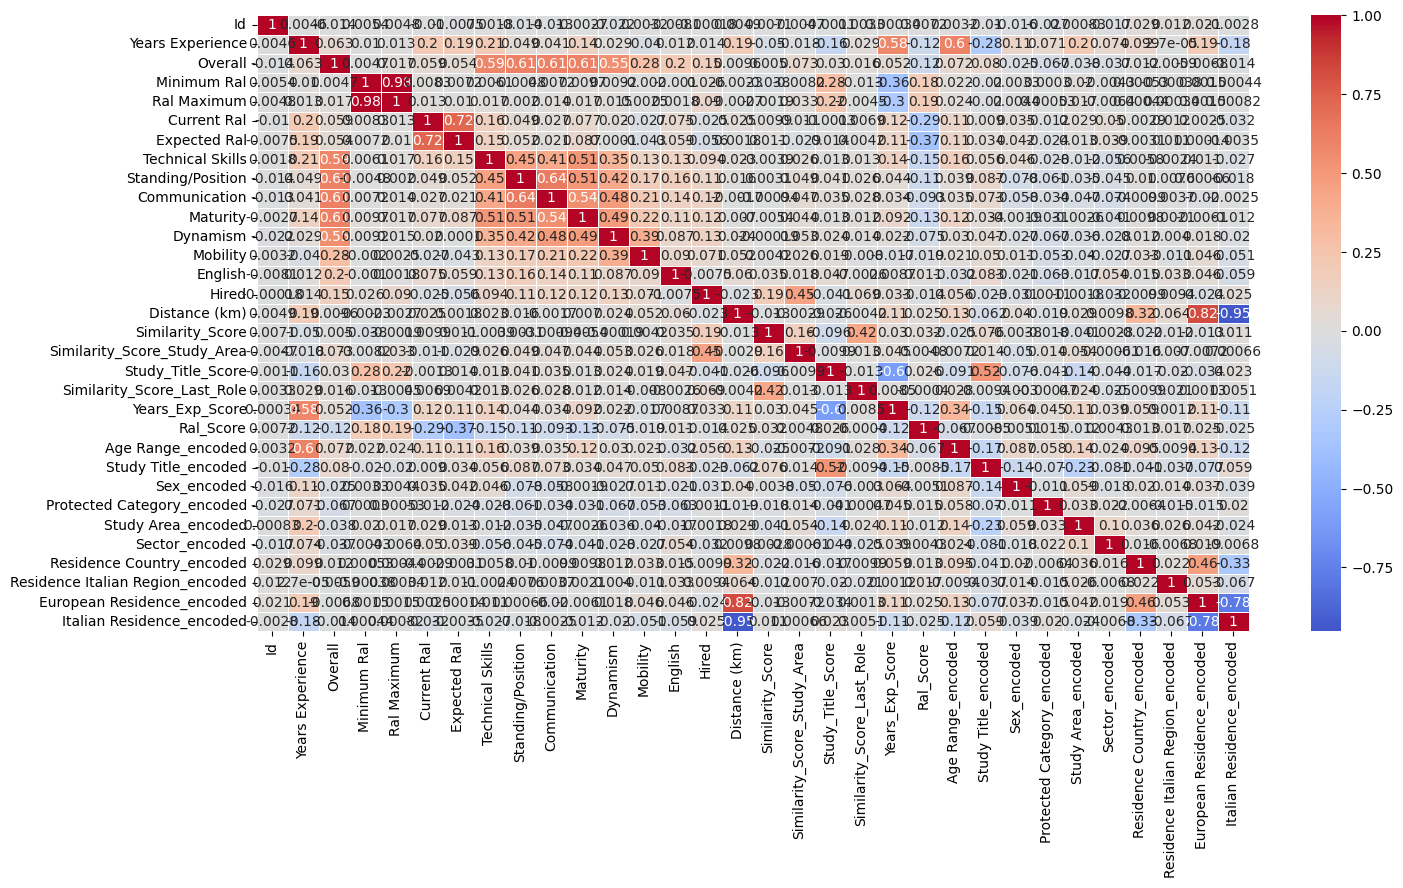

In [ ]:
# Correlation matrix
corr_matrix = data_set.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.show()

##Data Analysis

###Custom orders

###Hired

In [ ]:
data_set['Hired'].value_counts()

Hired
0    13685
1      430
Name: count, dtype: int64

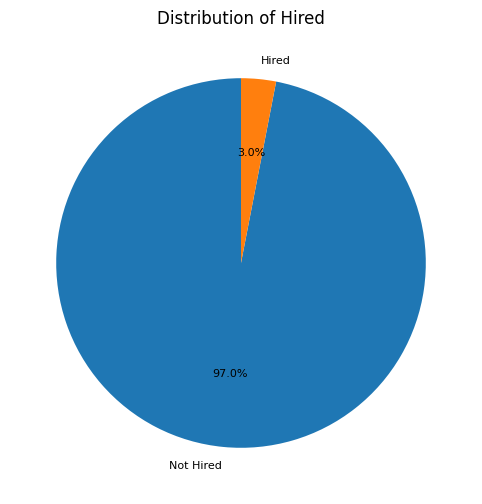

In [ ]:
getPie(data_set, 'Hired', reverse_mapping)

###Sex

In [ ]:
data_set['Sex_encoded'].value_counts()

Sex_encoded
1    11355
0     2760
Name: count, dtype: int64

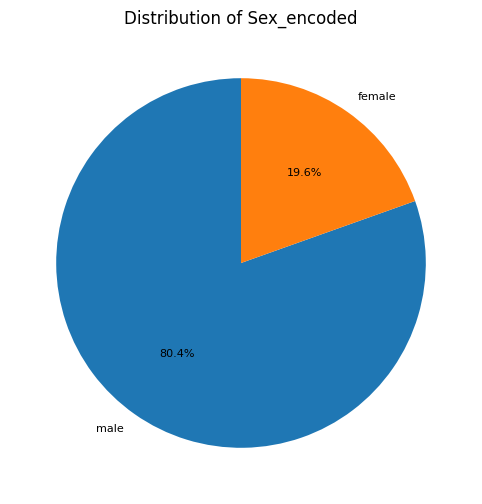

In [ ]:
getPie(data_set, 'Sex_encoded', reverse_mapping)

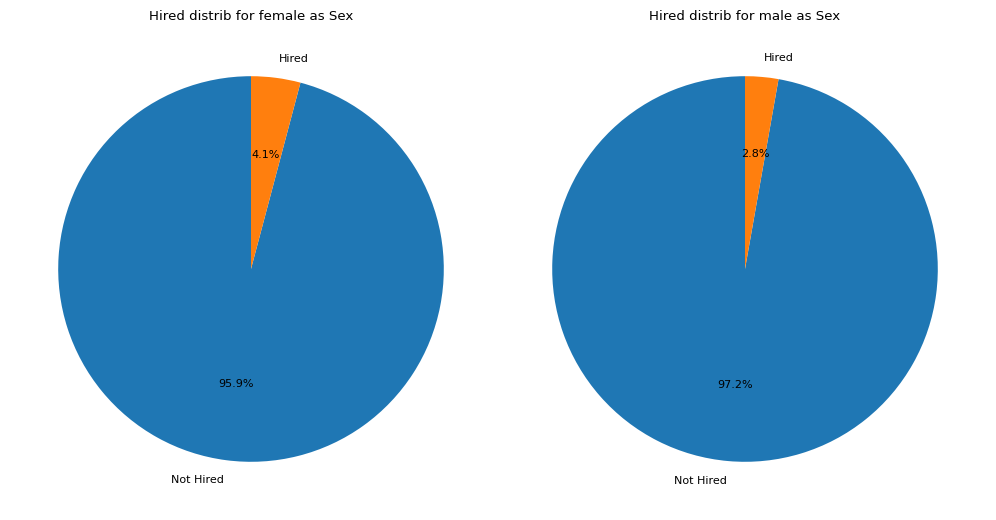

In [ ]:
plot_category_distributions(data_set, 'Sex_encoded', 'Hired', encoding_mappings, reverse_mapping)

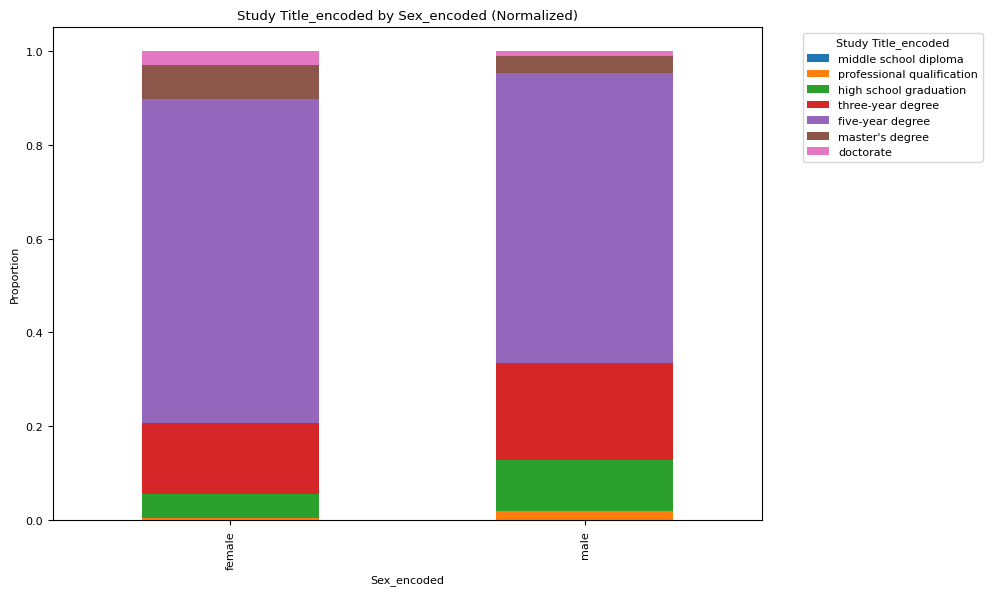

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

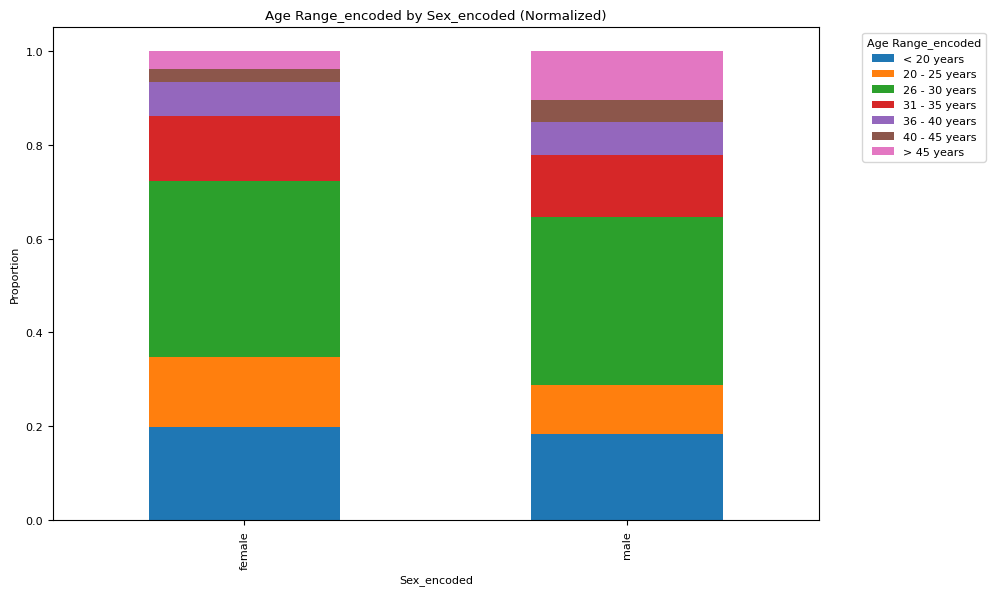

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Age Range_encoded', encoding_mappings, reverse_mapping)

In [ ]:
years_exp_rev_mapping = {
    v: k for k, v in years_exp_mapping.items()
}

In [ ]:
for k, v in reverse_std_mappings['Years Experience'].items():
  reverse_std_mappings['Years Experience'][k] = years_exp_rev_mapping[v]

In [ ]:
reverse_std_mappings['Sex_encoded'] = {}
reverse_std_mappings['Sex_encoded'][0] = 'female'
reverse_std_mappings['Sex_encoded'][1] = 'male'

std_mappings['Sex_encoded'] = {}
std_mappings['Sex_encoded']['female'] = 0
std_mappings['Sex_encoded']['male'] = 1

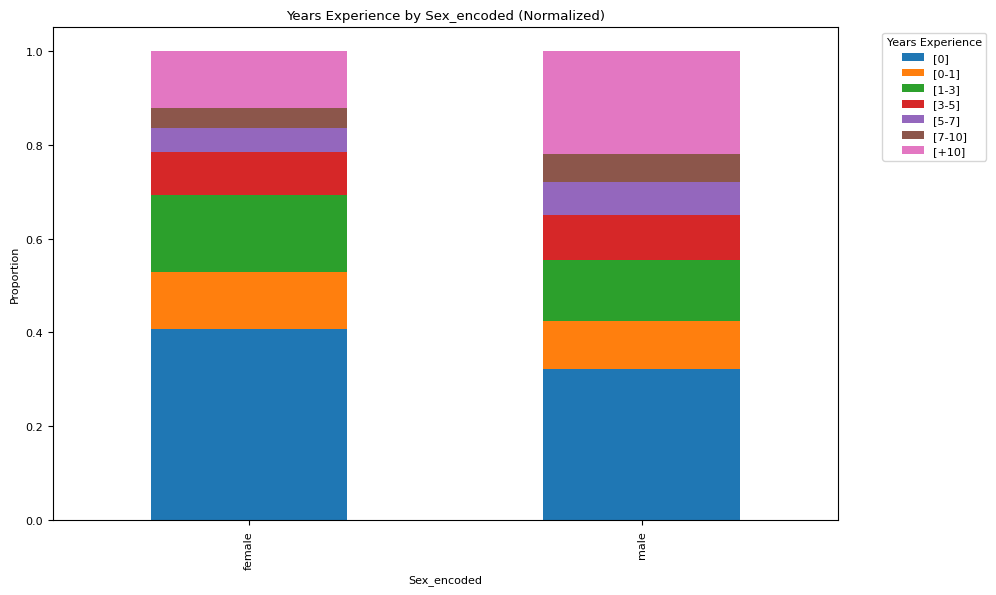

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Age Range

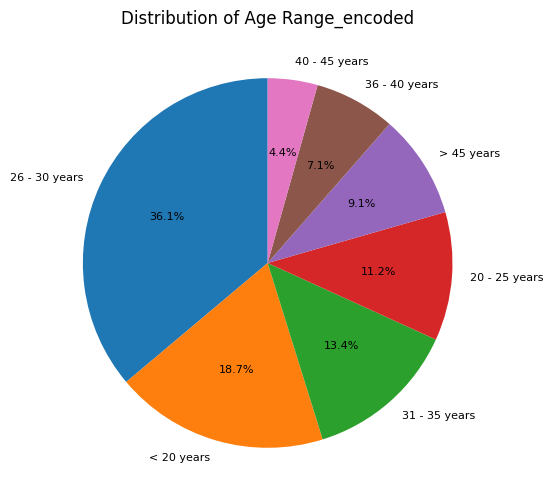

In [ ]:
getPie(data_set, 'Age Range_encoded', reverse_mapping)

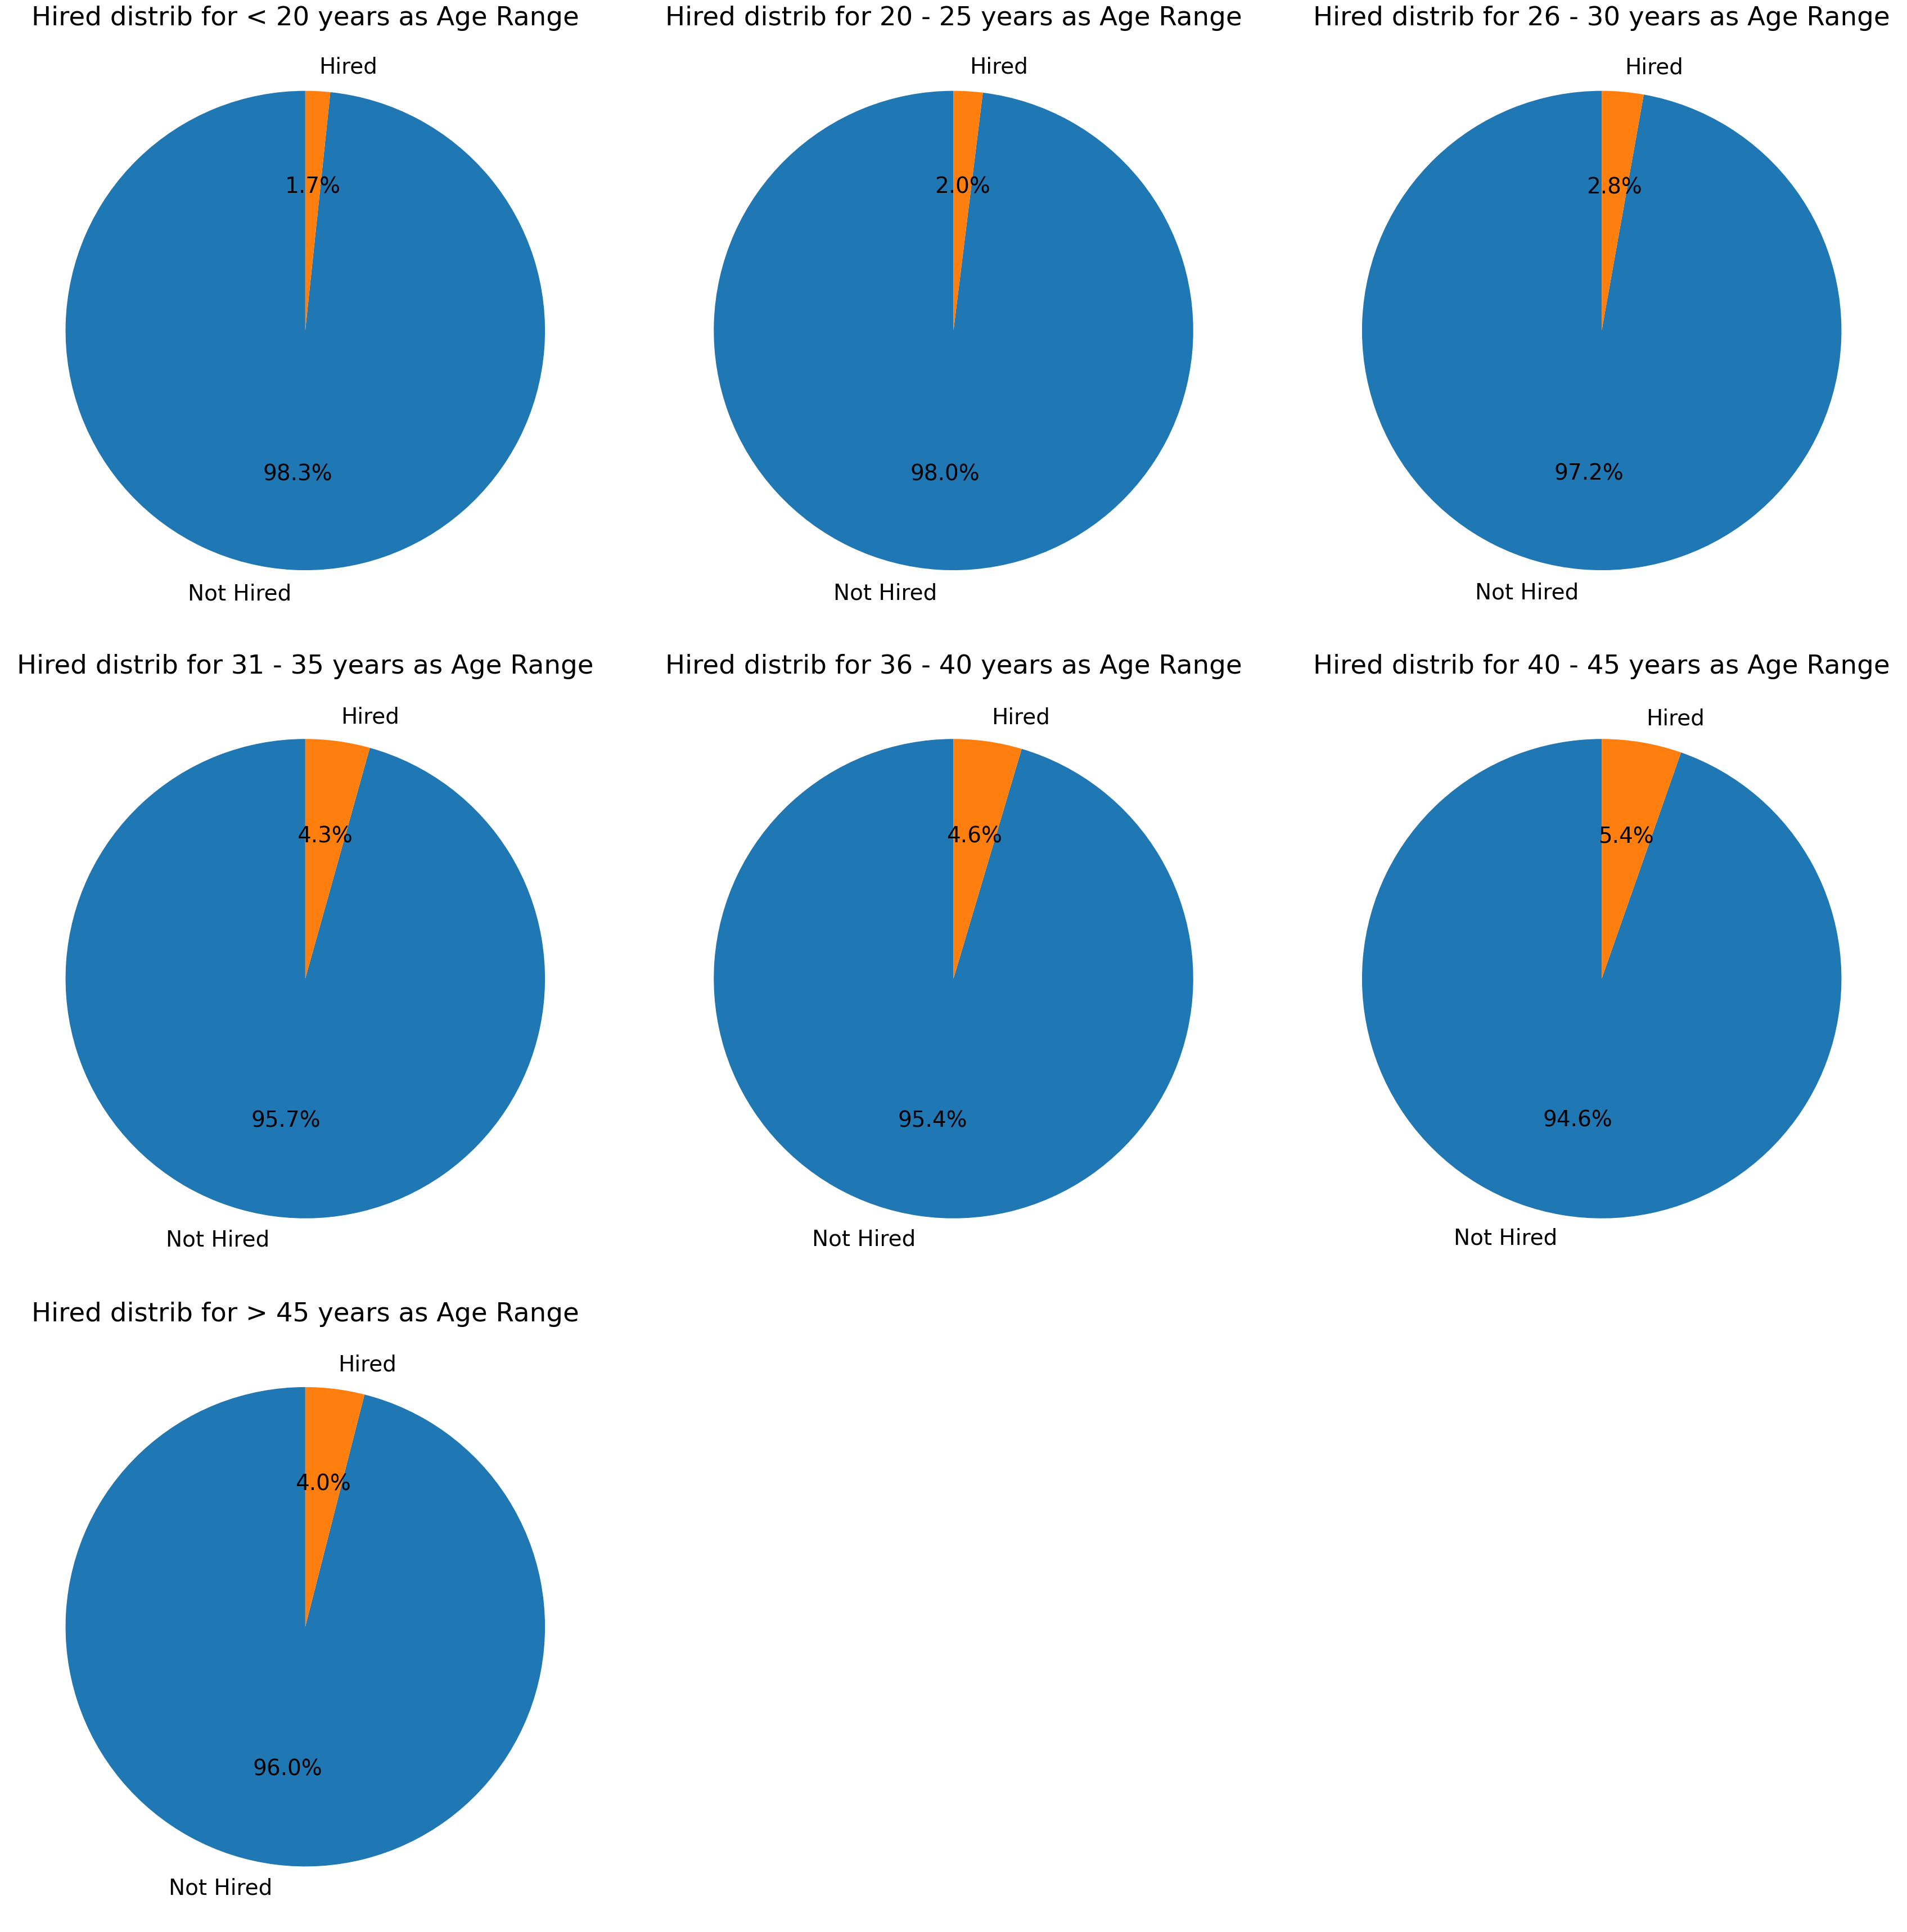

In [ ]:
plot_category_distributions(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

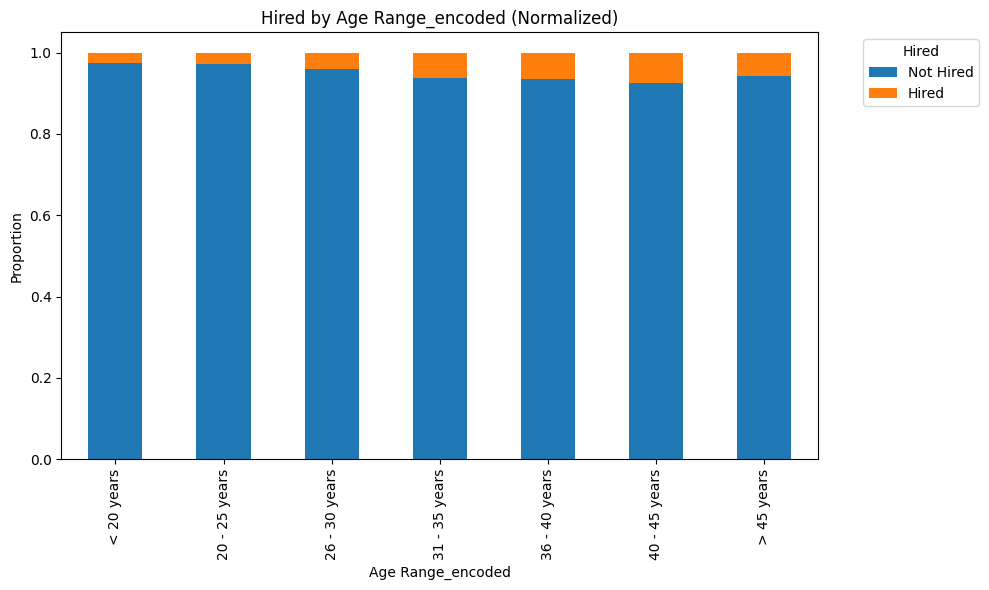

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

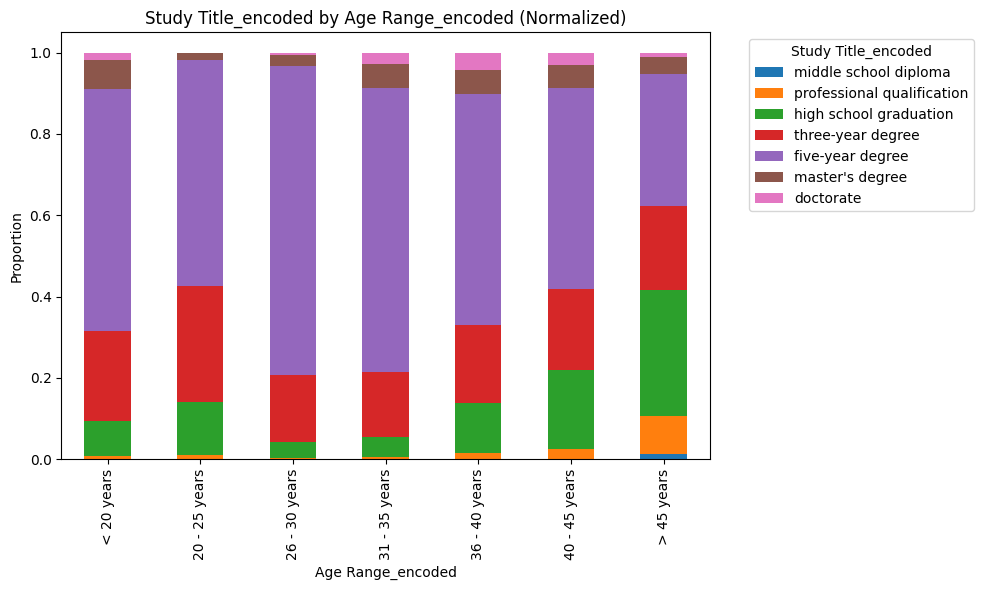

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

###Protected Category

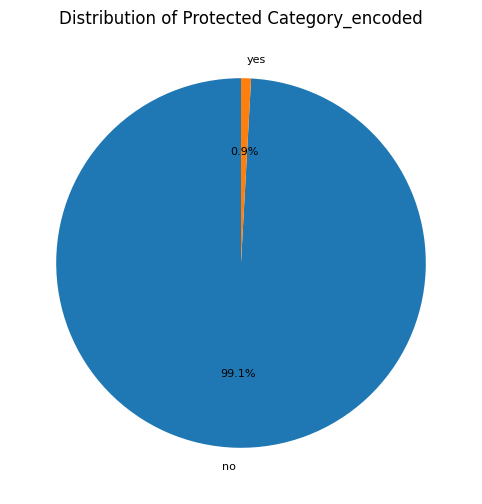

In [ ]:
getPie(data_set, 'Protected Category_encoded', reverse_mapping)

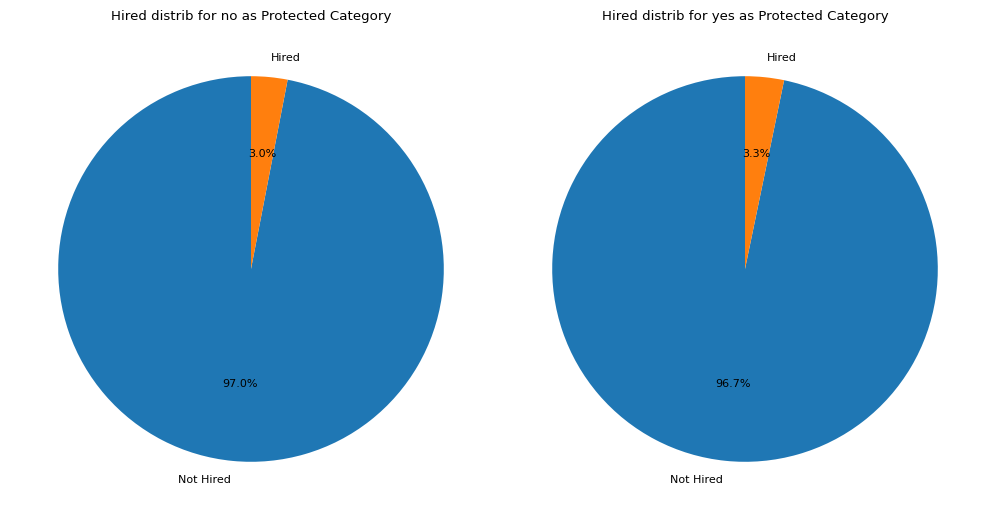

In [ ]:
plot_category_distributions(data_set, 'Protected Category_encoded', 'Hired', encoding_mappings, reverse_mapping)

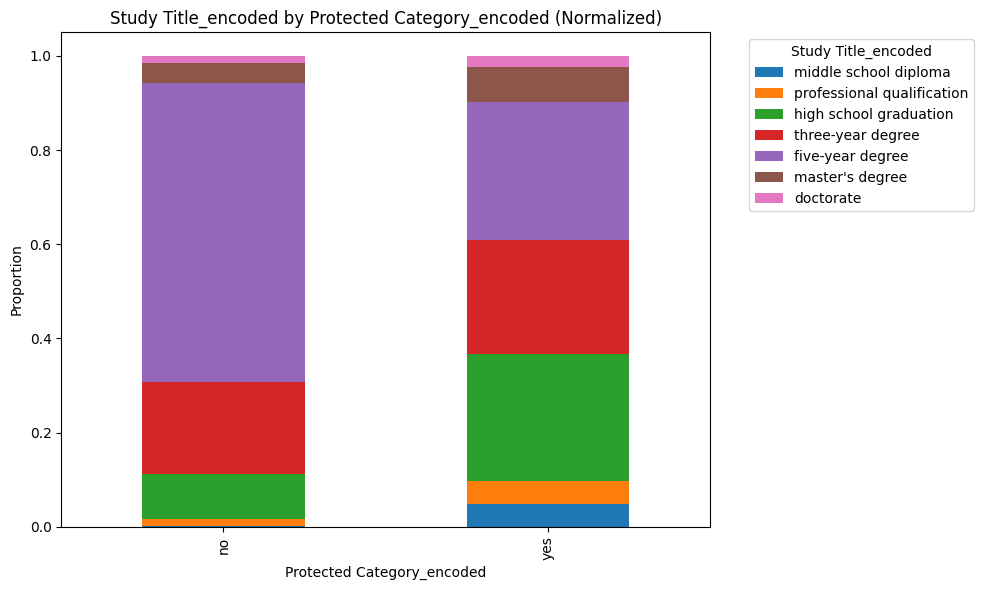

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Protected Category_encoded'] = encoding_mappings['Protected Category_encoded']
reverse_std_mappings['Protected Category_encoded'] = reverse_mapping['Protected Category_encoded']

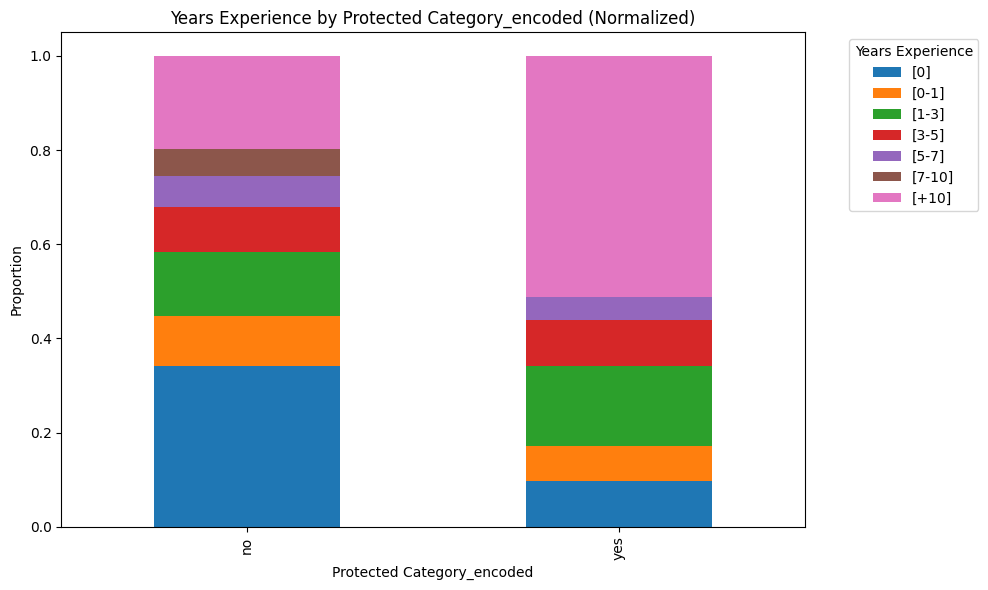

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Italian

In [ ]:
data_set['Italian_encoded'].value_counts()

Italian_encoded
1    13524
0      591
Name: count, dtype: int64

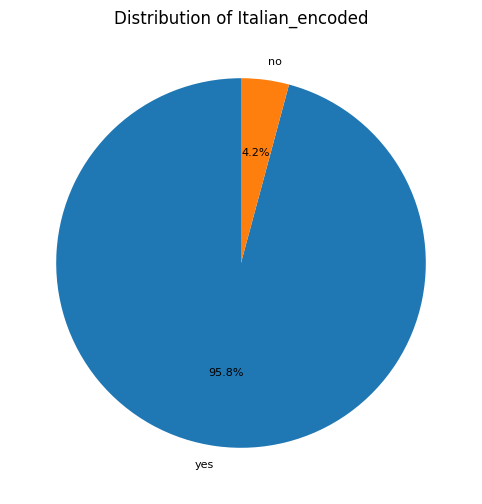

In [ ]:
getPie(data_set, 'Italian_encoded', reverse_mapping)

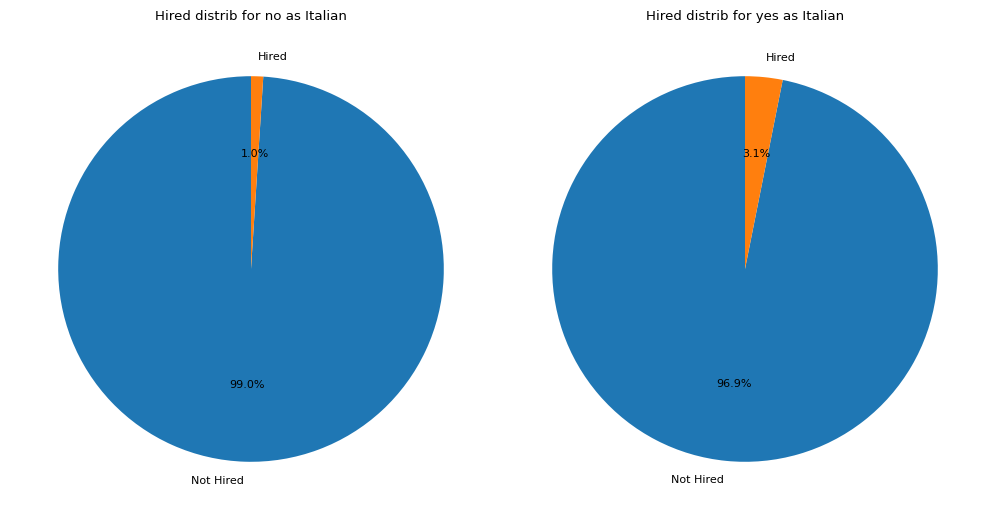

In [ ]:
plot_category_distributions(data_set, 'Italian_encoded', 'Hired', encoding_mappings, reverse_mapping)

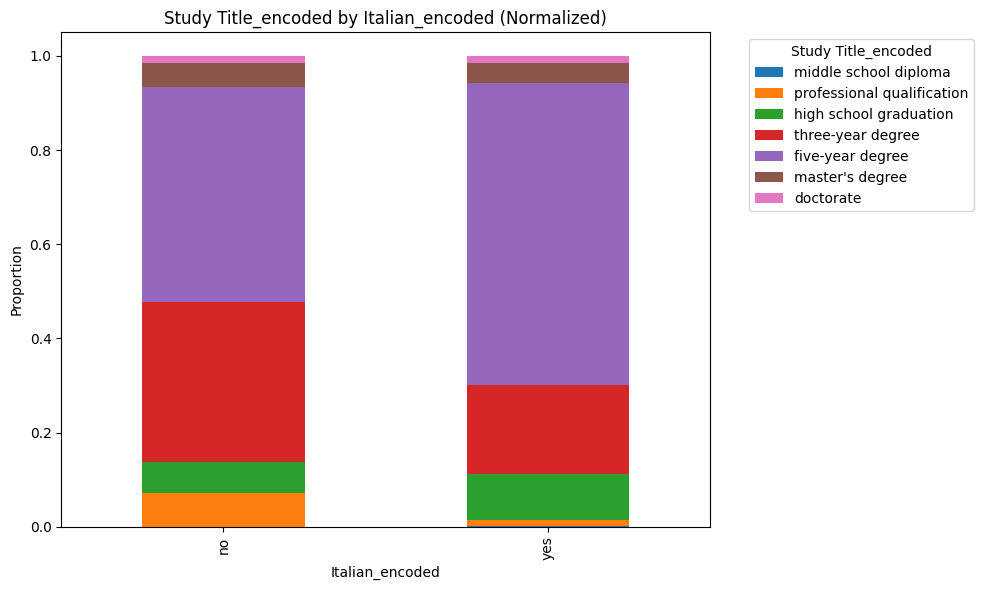

In [ ]:
plot_bar_norm(data_set, 'Italian_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Italian_encoded'] = encoding_mappings['Italian_encoded']
reverse_std_mappings['Italian_encoded'] = reverse_mapping['Italian_encoded']

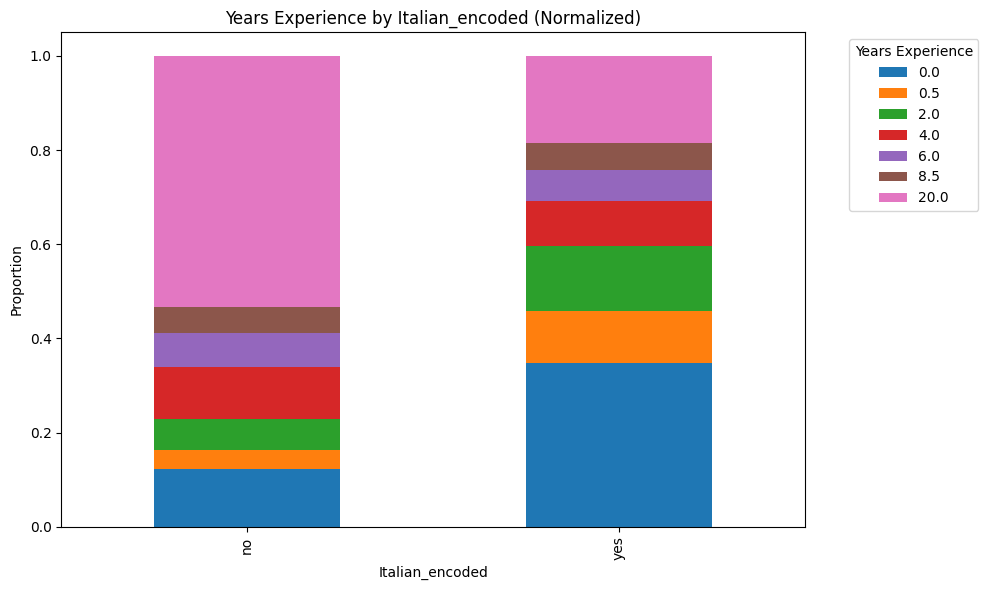

In [ ]:
plot_bar_norm(data_set, 'Italian_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

##GRIDSEARCH

###Train Val Test split

In [42]:
data_set = shuffle(data_set, random_state=random_state)
train_val_set, test_set = train_test_split(data_set, test_size=0.25, stratify=data_set[['Hired', 'Protected Category_encoded']], random_state=random_state)

ctgan = CTGAN(verbose=True)

minority_class = train_val_set[train_val_set['Hired'] == 1]
categorical_features = [f"{col}_encoded" for col in categorical_columns]

ctgan.fit(minority_class, categorical_features, epochs=300)


Gen. (-1.54) | Discrim. (0.14): 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]


In [43]:
n = train_val_set[train_val_set['Hired'] == 0].shape[0]
samples = ctgan.sample(n)

for col in categorical_features:
    samples = samples[samples[col].isin(train_val_set[col].unique())]
print(f"{n - len(samples)} samples removed")

samples['Id'] = samples['Id'].apply(lambda x: x if x < 0 else -x)

0 samples removed


In [44]:
balanced_train_set = pd.concat([samples, train_val_set], ignore_index=True)
balanced_train_set = shuffle(balanced_train_set, random_state=random_state)

X_train = balanced_train_set.drop(columns=['Hired', 'Id'])
y_train = balanced_train_set['Hired']
X_test = test_set.drop(columns=['Hired', 'Id'])
y_test = test_set['Hired']

split_index = [-1 if i not in train_val_set.index else 0 for i in balanced_train_set.index]
cv = PredefinedSplit(test_fold=split_index)

###Models

In [48]:
model_list = ['dt' # decision tree
             ,'lr' #Linear Regression
             ,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             ,'lp'   # linear perceptron
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             ]

model_params = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{
                      'n_neighbors': list(range(1,10)),
                      #'leaf_size': (20,40,1),
                      #'p': (1,2),
                      'weights': ('uniform', 'distance'),
                      'metric': ['euclidean', 'manhattan'],
                      }]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,20,4)],
                      'n_estimators':[*range(10,30,5)],
                      'class_weight': [None,'balanced']
                      }]
          },
    'xgb': {'name': 'XGBoost             ',
           'estimator': XGBClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,30,4)],
                      'n_estimators':[*range(10,30,5)]
                      }]
          },
    'lr': {'name': 'Linear Regression   ',
           'estimator': LinearRegression(),
           'param': [{
               'fit_intercept': [True, False],
               'positive': [True,False]}]
          }

}

In [46]:
scorings = ['accuracy',
            'precision_macro',
            'recall_macro',
            'f1_macro',
            ]

In [49]:
from sklearn.model_selection import ParameterGrid
trials = {m: len(list(ParameterGrid(model_params[m]['param']))) for m in model_list}
trials

{'dt': 38, 'lr': 4, 'nb': 9, 'rf': 32, 'lp': 4, 'knn': 36, 'adb': 20}

In [50]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import PredefinedSplit

def binarized_f1(y_true, y_pred):
    return f1_score(y_true, (y_pred > 0.5).astype(int))

results = []
clfs = {}
predictions = {}

for scoring in scorings:
    print(f"\n\nGridsearch with scoring {scoring}:\n")
    clfs[scoring] = []
    for m in model_list:
        print(f"Training model: {model_params[m]['name']}")
        if m == 'lr':
          clf = GridSearchCV(
              model_params[m]['estimator'],
              model_params[m]['param'],
              cv=cv,
              scoring=make_scorer(binarized_f1),
              n_jobs=-1
          )
        else:
          clf = GridSearchCV(
              model_params[m]['estimator'],
              model_params[m]['param'],
              cv=cv,
              scoring=scoring,
              n_jobs=-1
          )

        clf.fit(X_train, y_train)
        y_true, y_pred = y_test, clf.predict(X_test)

        if m == 'lr':
            y_pred = (y_pred > 0.5).astype(int)
        if m not in predictions:
            predictions[m] = {}
        predictions[m][scoring] = y_pred

        cr = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        results.append({
            'scoring': scoring,
            'model': model_params[m]['name'],
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision': cr['macro avg']['precision'],
            'recall': cr['macro avg']['recall'],
            'f1_score': cr['macro avg']['f1-score']
        })

        clfs[scoring].append(clf)

results_df = pd.DataFrame(results)




Gridsearch with scoring accuracy:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring precision_macro:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring recall_macro:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring f1_macro:

Training model: Decision Tree       
Training model: Linear Regression

In [51]:
for score in scorings:
    scoring_filter = score
    display(results_df[results_df.scoring==scoring_filter]\
                .sort_values(by='f1_score',ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('\n\nResults for scoring "{}"'.format(scoring_filter)))

In [52]:
best_model_params = {}

for scoring in scorings:
  best_model_params[scoring] = {}
  for m in model_list:
      best_model_params[scoring][m] = {
          'name': model_params[m]['name'],
          'estimator': clfs[scoring][model_list.index(m)].best_estimator_
      }

In [53]:
best_model_params

{'accuracy': {'dt': {'name': 'Decision Tree       ',
   'estimator': DecisionTreeClassifier(max_depth=6, random_state=42)},
  'lr': {'name': 'Linear Regression   ', 'estimator': LinearRegression()},
  'nb': {'name': 'Gaussian Naive Bayes',
   'estimator': GaussianNB(var_smoothing=1e-08)},
  'rf': {'name': 'Random forest       ',
   'estimator': RandomForestClassifier(max_depth=16, n_estimators=20, random_state=42)},
  'lp': {'name': 'Linear Perceptron   ',
   'estimator': Perceptron(early_stopping=True, random_state=42)},
  'knn': {'name': 'K Nearest Neighbor ',
   'estimator': KNeighborsClassifier(metric='euclidean', n_neighbors=1)},
  'adb': {'name': 'AdaBoost           ',
   'estimator': AdaBoostClassifier(learning_rate=1.25, random_state=42)}},
 'precision_macro': {'dt': {'name': 'Decision Tree       ',
   'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=11, random_state=42)},
  'lr': {'name': 'Linear Regression   ', 'estimator': LinearRegression()},
  'nb': {

In [54]:
with open(drive_dir+best_models_dict, 'wb') as f:
    pickle.dump(best_model_params, f)

In [ ]:
with open(drive_dir+best_models_dict, 'rb') as f:
    best_model_params_loaded = pickle.load(f)

###Neural Networks

In [ ]:
model = CustomKerasClassifier(input_shape=(X_train.shape[1],))

param_grid = {
    'neurons': [64, 128, 256],
    'activation': ['relu', 'elu', 'tanh'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 20, 30, 50],
    'learning_rate': [0.001, 0.01, 0.1]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=15, cv=cv, scoring='recall' , n_jobs=1,
                                  verbose=2, random_state = random_state)

grid_result = random_search.fit(X_train, y_train)

print(f"Best params: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Fitting 1 folds for each of 15 candidates, totalling 15 fits
Epoch 1/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7619 - loss: 0.7950
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8629 - loss: 0.5368
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8846 - loss: 0.4556
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9014 - loss: 0.4200
Epoch 5/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9091 - loss: 0.3830
Epoch 6/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9131 - loss: 0.3656
Epoch 7/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9157 - loss: 0.3612
Epoch 8/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9213 - loss: 0.3449
Epoch 9/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9245 - loss: 0.3291
Epoch 10/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9254 - loss: 0.3204
Epoch 11/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9261 - los

In [ ]:
best_params_nn = grid_result.best_params_

with open(drive_dir+best_params_nn_dict, 'wb') as f:
    pickle.dump(best_params_nn, f)

In [69]:
with open(drive_dir+best_params_nn_dict, 'rb') as f:
    best_params_nn = pickle.load(f)

In [ ]:
best_params_nn

{'optimizer': 'rmsprop',
 'neurons': 128,
 'learning_rate': 0.001,
 'epochs': 30,
 'batch_size': 32,
 'activation': 'elu'}

##Training

### Train Test Val Split


In [60]:
#train_val_set, test_set = train_test_split(data_set, test_size=0.25, stratify=data_set['Hired'], random_state=random_state)
train_set, validation_set = train_test_split(train_val_set, test_size=0.2, stratify=train_val_set[['Hired', 'Protected Category_encoded']], random_state=random_state)

balanced_train_set = pd.concat([samples, train_set], ignore_index=True)
balanced_train_set = shuffle(balanced_train_set, random_state=random_state)

X_train = balanced_train_set.drop(columns=['Hired', 'Id'])
y_train = balanced_train_set['Hired']
#X_train = train_set.drop(columns=['Hired', 'Id'])
#y_train = train_set['Hired']
X_validation = validation_set.drop(columns=['Hired', 'Id'])
y_validation = validation_set['Hired']
X_test = test_set.drop(columns=['Hired', 'Id'])
y_test = test_set['Hired']

###Models

In [61]:
train_set_models = pd.concat([balanced_train_set, validation_set], ignore_index=True)
train_set_models = shuffle(train_set_models, random_state=random_state)

X_train_models = train_set_models.drop(columns=['Hired', 'Id'])
y_train_models = train_set_models['Hired']

In [57]:
models = {best_model_params['recall_macro'][m]['name'].rstrip(): best_model_params['recall_macro'][m]['estimator'] for m in best_model_params['recall_macro'].keys()}

In [62]:
metrics = []
predictions = {}

for name, model in models.items():
    fit_predict_model(name, model, X_train_models, y_train_models, X_test, y_test, metrics, predictions)

metrics = pd.DataFrame(metrics)


Fitting Decision Tree...
Fitting Linear Regression...
Fitting Gaussian Naive Bayes...
Fitting Random forest...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...


In [64]:
metrics.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.988      0.920   0.645     0.758    0.898
1     Linear Regression     0.914      0.206   0.645     0.312    0.884
3         Random forest     0.988      0.970   0.607     0.747    0.967
6              AdaBoost     0.980      0.709   0.570     0.632    0.964
4     Linear Perceptron     0.937      0.252   0.542     0.344    0.746
2  Gaussian Naive Bayes     0.870      0.122   0.533     0.199    0.848
5    K Nearest Neighbor     0.938      0.049   0.056     0.052    0.511

###Neural Networks

In [72]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [78]:
neural_models = []
neural_predictions = []
histories = []

i = 0
for seed in range(85, 88):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models, histories, X_train, y_train, X_validation, y_validation, X_test, neural_predictions, best_params_nn, early_stopping=early_stopping)

Fitting model Neural Network 1...
Epoch 1/20
586/586 [==============================] - 3s 3ms/step - loss: 0.3193 - accuracy: 0.8252 - val_loss: 0.1386 - val_accuracy: 0.9632
Epoch 2/20
586/586 [==============================] - 2s 3ms/step - loss: 0.2223 - accuracy: 0.8829 - val_loss: 0.3258 - val_accuracy: 0.9046
Epoch 3/20
586/586 [==============================] - 2s 3ms/step - loss: 0.1914 - accuracy: 0.9034 - val_loss: 0.1699 - val_accuracy: 0.9537
Epoch 4/20
586/586 [==============================] - 2s 3ms/step - loss: 0.1717 - accuracy: 0.9159 - val_loss: 0.1604 - val_accuracy: 0.9528
Epoch 5/20
586/586 [==============================] - 2s 4ms/step - loss: 0.1501 - accuracy: 0.9288 - val_loss: 0.1275 - val_accuracy: 0.9608
Epoch 6/20
586/586 [==============================] - 1s 2ms/step - loss: 0.1421 - accuracy: 0.9330 - val_loss: 0.1544 - val_accuracy: 0.9547
Epoch 7/20
586/586 [==============================] - 2s 3ms/step - loss: 0.1261 - accuracy: 0.9415 - val_loss: 0.

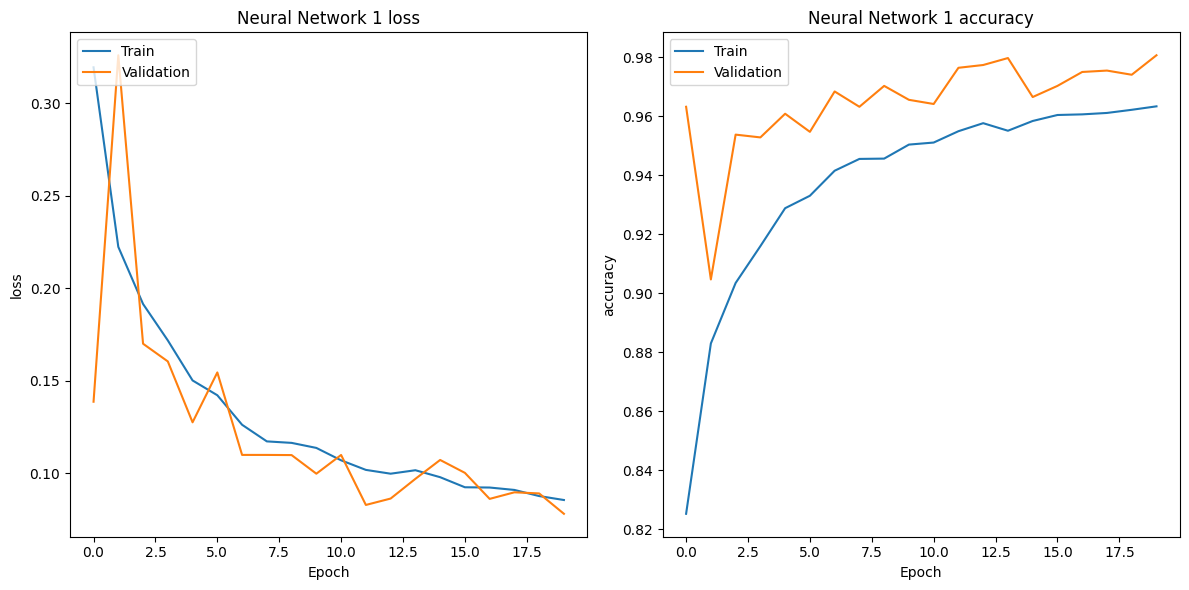

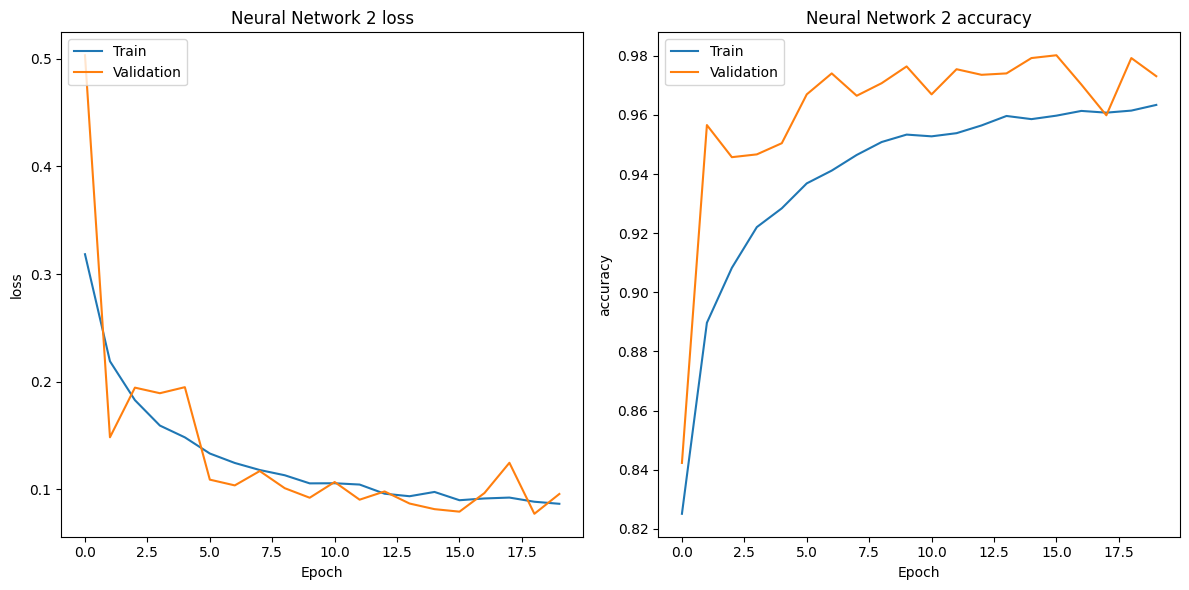

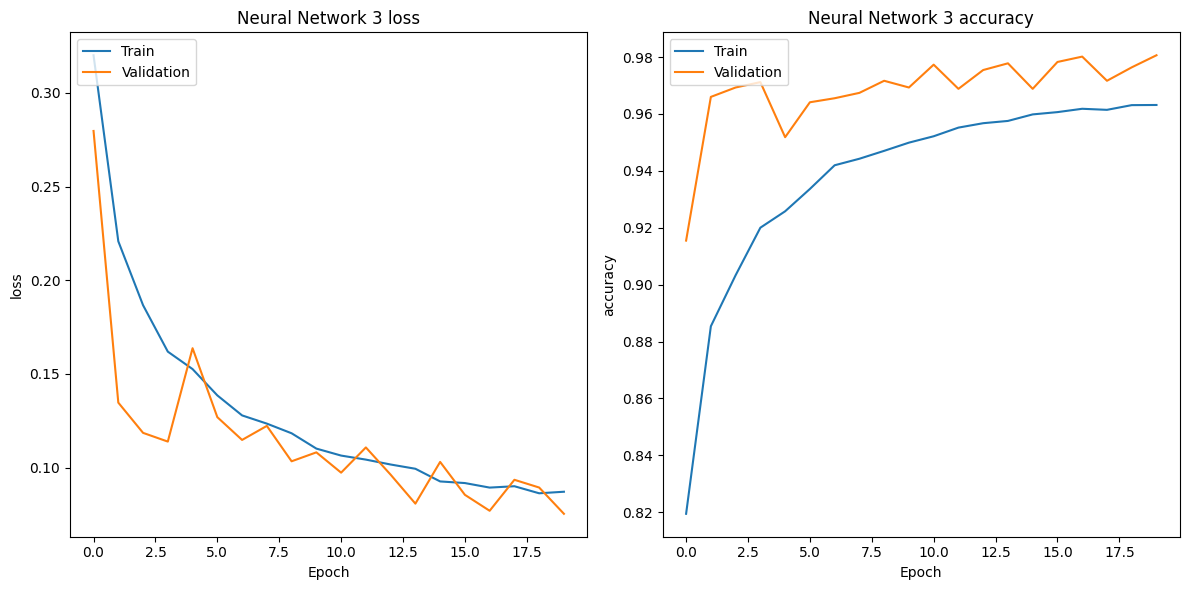

In [79]:
for i, h in enumerate(histories):
  name = f"Neural Network {i+1}"
  plot_val_train(h.history, name)

#### NN export

In [ ]:
import os

if not os.path.exists('NNs'):
    os.makedirs('NNs')

for i, model in enumerate(neural_models):
    model.save(f'NNs/neural_network_model{i}.keras')


In [ ]:
!cp -r NNs/ $drive_dir

####NN import

In [ ]:
source_path = drive_dir + 'NNs/'
!cp -r $source_path NNs/

In [ ]:
neural_models = []

for i in range(0,3):
  source_path = f'new_NNs/new_NNs/neural_network_model{i}'
  model = load_model(source_path)
  neural_models.append(model)


In [80]:
i = 0
neural_predictions = []
for nn in neural_models:
  name = f"Neural Network {i}"
  predict_nn(name, nn, X_test, neural_predictions)
  i+=1

Predicting with model Neural Network 0...
111/111 [==============================] - 0s 1ms/step
Predictions from model Neural Network 0 stored.


Predicting with model Neural Network 1...
111/111 [==============================] - 0s 2ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
111/111 [==============================] - 0s 2ms/step
Predictions from model Neural Network 2 stored.




In [81]:
nn_metrics = []

for i, y_pred in enumerate(neural_predictions):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics, name)

nn_metrics = pd.DataFrame(nn_metrics)
nn_metrics.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
1  Neural Network 2     0.980      0.640   0.748     0.690    0.867
2  Neural Network 3     0.988      0.874   0.710     0.784    0.854
0  Neural Network 1     0.986      0.878   0.607     0.718    0.802

### Combined Performance

In [82]:
combined_metrics = pd.concat([metrics, nn_metrics], ignore_index=True)
combined_metrics

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.988      0.920   0.645     0.758    0.898
1     Linear Regression     0.914      0.206   0.645     0.312    0.884
2  Gaussian Naive Bayes     0.870      0.122   0.533     0.199    0.848
3         Random forest     0.988      0.970   0.607     0.747    0.967
4     Linear Perceptron     0.937      0.252   0.542     0.344    0.746
5    K Nearest Neighbor     0.938      0.049   0.056     0.052    0.511
6              AdaBoost     0.980      0.709   0.570     0.632    0.964
7      Neural Network 1     0.986      0.878   0.607     0.718    0.802
8      Neural Network 2     0.980      0.640   0.748     0.690    0.867
9      Neural Network 3     0.988      0.874   0.710     0.784    0.854

In [83]:
for i,model in enumerate(neural_models):
  models[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions):
  predictions[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection

In [84]:
# Columns groups of interest
sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian Residence_encoded', 'European Residence_encoded', 'Protected Category_encoded']
non_sensitive_features = data_set.columns.difference(sensitive_features)

# Tresholds
tolerance = 0.1
significance_level = 0.1

###Demographic Parity

In [85]:
getFairnessTab(calculate_demographic_parity,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Age Range_encoded
< 20 years: 0.05597579425113464
20 - 25 years: 0.05357142857142857
26 - 30 years: 0.0649452269170579
31 - 35 years: 0.11016949152542373
36 - 40 years: 0.16740088105726872
40 - 45 years: 0.17419354838709677
> 45 years: 0.2238372093023256
Model unfair to: 20 - 25 years


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Italian Residence_encoded
no: 0.20496894409937888
yes: 0.08966745843230403
Model unfair to: yes


===============================UNFAIR!===============================
Model GaussianNB(var_smoothing=1e-08) unfair wrt Age Range_encoded
< 20 years: 0.13161875945537066
20 - 25 years: 0.05612244897959184
26 - 30 years: 0.0649452269170579
31 - 35 years: 0.12076271186440678
36 - 40 years: 0.2026431718061674
40 - 45 years: 0.3032258064516129
> 45 years: 0.3633720930232558
Model unfair to: 20 - 25 years

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                                                                  
Linear Regression                    20 - 25 years                       yes   
Gaussian Naive Bayes                 20 - 25 years                       yes   
Random forest                                                                  
Linear Perceptron                       < 20 years                             
K Nearest Neighbor                      < 20 years                             
AdaBoost                                < 20 years                             
Neural Network 1                                                               
Neural Network 2                        < 20 years                             
Neural Network 3                                                               

                     European Residence_encoded Protected Category_encoded  
Decision Tree                                                               
Linear Regression                                                           
Gaussian Naive Bayes                   european                         no  
Random forest                                                               
Linear Perceptron                                                           
K Nearest Neighbor                                                          
AdaBoost                                                                    
Neural Network 1                                                            
Neural Network 2                                                            
Neural Network 3

### Equalized Odds

In [ ]:
getFairnessTab(calculate_equalized_odds,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Age Range_encoded
Maximum TPR difference: 0.5855 between group 26 - 30 years and group > 45 years
Model unfair to: > 45 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.7105, FPR=0.0008
Group 31 - 35 years: TPR=0.4706, FPR=0.0022
Group 40 - 45 years: TPR=0.3077, FPR=0.0000
Group > 45 years: TPR=0.1250, FPR=0.0032
Group 20 - 25 years: TPR=0.7000, FPR=0.0000
Group 36 - 40 years: TPR=0.4706, FPR=0.0045
Group < 20 years: TPR=0.6000, FPR=0.0000


===============================UNFAIR!===============================
Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Italian Residence_encoded
Maximum TPR difference: 0.5472 between group yes and group no
Model unfair to: no
TPR and FPR for each group:
Group yes: TPR=0.5472, FPR=0.0000
Group no: TPR=0.0000, FPR=0.0282




There are no positive examples for the group non-europe

Sex_encoded         Age Range_encoded  \
Decision Tree                                   > 45 years   
Linear Regression                 < 20 years 20 - 25 years   
Gaussian Naive Bayes                         20 - 25 years   
Random forest                                   > 45 years   
Linear Perceptron                               > 45 years   
K Nearest Neighbor                           20 - 25 years   
AdaBoost                                        > 45 years   
Neural Network 1                                > 45 years   
Neural Network 2                                > 45 years   
Neural Network 3                                > 45 years   

                     Italian Residence_encoded European Residence_encoded  \
Decision Tree                               no               non-european   
Linear Regression                          yes               non-european   
Gaussian Naive Bayes                       yes      non-european european   
Random forest                               no               non-european   
Linear Perceptron                                            non-european   
K Nearest Neighbor                                                          
AdaBoost                                                     non-european   
Neural Network 1                           yes               non-european   
Neural Network 2                            no               non-european   
Neural Network 3                            no               non-european   

                     Protected Category_encoded  
Decision Tree                                no  
Linear Regression                            no  
Gaussian Naive Bayes                         no  
Random forest                                no  
Linear Perceptron                            no  
K Nearest Neighbor                               
AdaBoost                                     no  
Neural Network 1                             no  
Neural Network 2                             no  
Neural Network 3                             no

###Counterfactual Fairness

In [ ]:
getFairnessTab(
    calculate_counterfactual_fairness,
    models=models,
    sensitive_features= sensitive_features,
    predictions=predictions,
    index=list(models.keys()),
    X_test=X_test,
    significance_level=significance_level,
    tolerance=tolerance,
    verbose=True
)

Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: female 0.0000
Most discriminated group: female 0.0000
Most privileged group: female 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: 26 - 30 years 0.0000
Most discriminated group: 26 - 30 years 0.0000
Most privileged group: 26 - 30 years 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: yes 0.0000
Most discriminated group: yes 0.0000
Most privileged group: yes 0.0000
Direction of bias (negative = worse, positive = better)


Model Decision

Sex_encoded  \
Decision Tree                      
Linear Regression                  
Gaussian Naive Bayes               
Random forest                      
Linear Perceptron                  
K Nearest Neighbor                 
AdaBoost                           
Neural Network 1                   
Neural Network 2                   
Neural Network 3                   

                                                      Age Range_encoded  \
Decision Tree                                                             
Linear Regression                                                         
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor    (< 20 years, 0.0019835647492207425, > 45 years...   
AdaBoost                                                                  
Neural Network 1      (< 20 years, -0.0028336639274582033, > 45 year...   
Neural Network 2                                                          
Neural Network 3      (< 20 years, -0.0031170303202040237, > 45 year...   

                                              Italian Residence_encoded  \
Decision Tree                                                             
Linear Regression                                                         
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (yes, 0.018135449135732503, no, 0.324737886086...   
Neural Network 2      (yes, 0.002266931141966563, no, 0.103995466137...   
Neural Network 3      (yes, 0.0028336639274582033, no, 0.14338339472...   

                                             European Residence_encoded  \
Decision Tree                                                             
Linear Regression                                                         
Gaussian Naive Bayes  (european, -0.003400396712949844, non-european...   
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (european, 0.005383961462170587, non-european,...   
Neural Network 2      (european, 0.0005667327854916407, non-european...   
Neural Network 3      (european, 0.000850099178237461, non-european,...   

                                             Protected Category_encoded  
Decision Tree                                                            
Linear Regression                                                        
Gaussian Naive Bayes  (no, -0.007367526211391329, yes, 0.89260413714...  
Random forest                                                            
Linear Perceptron                                                        
K Nearest Neighbor                                                       
AdaBoost                                                                 
Neural Network 1                                                         
Neural Network 2                                                         
Neural Network 3

##Explainers

###LIME (Local Interpretable Model-agnostic Explanations)
explanations for samples with index = 16,17,18, with the top 5 most relevant features.

LIME EXPLANATIONS FOR Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 500x300 with 0 Axes>

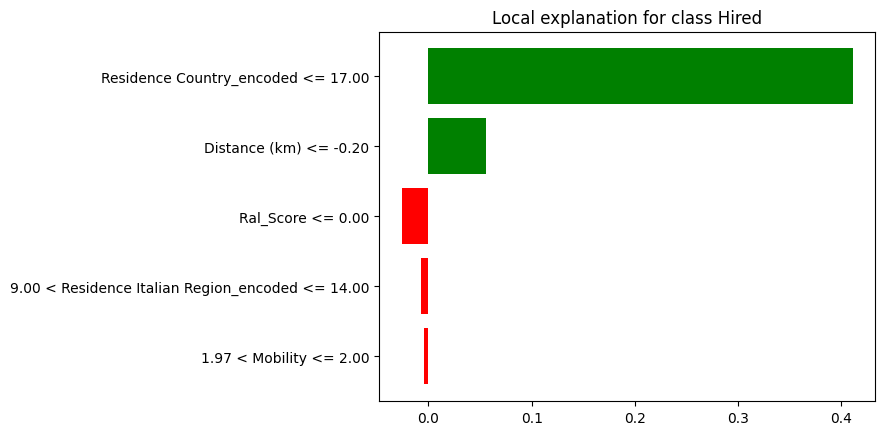

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


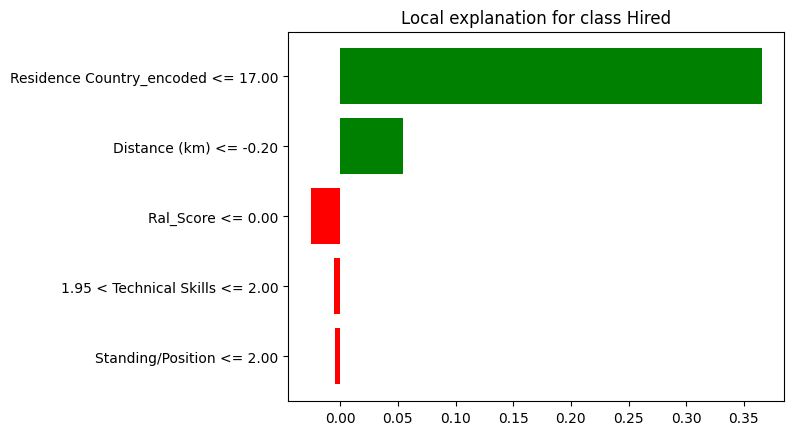

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


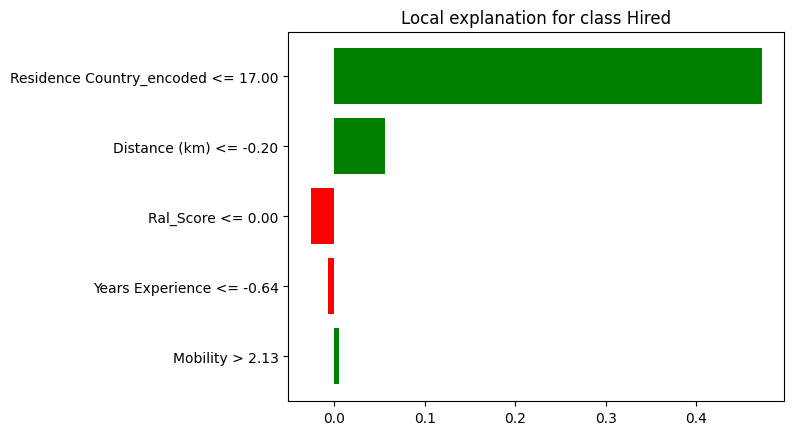

LIME EXPLANATIONS FOR Gaussian Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


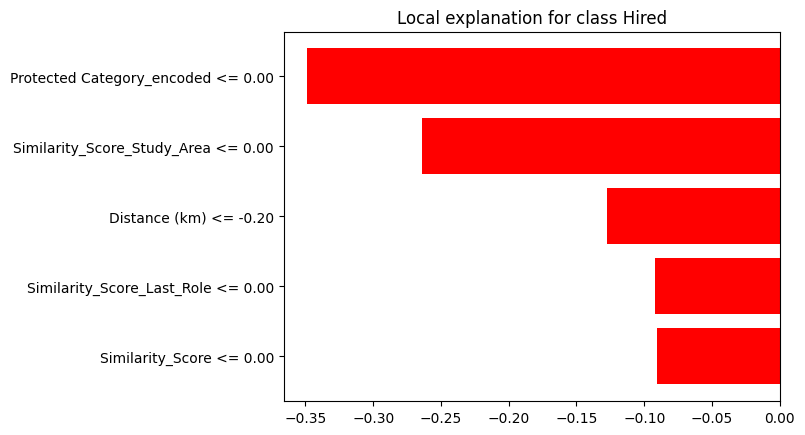

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


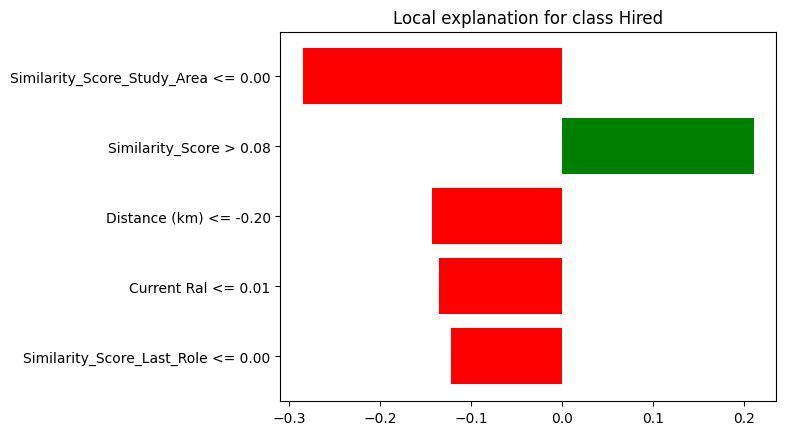

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


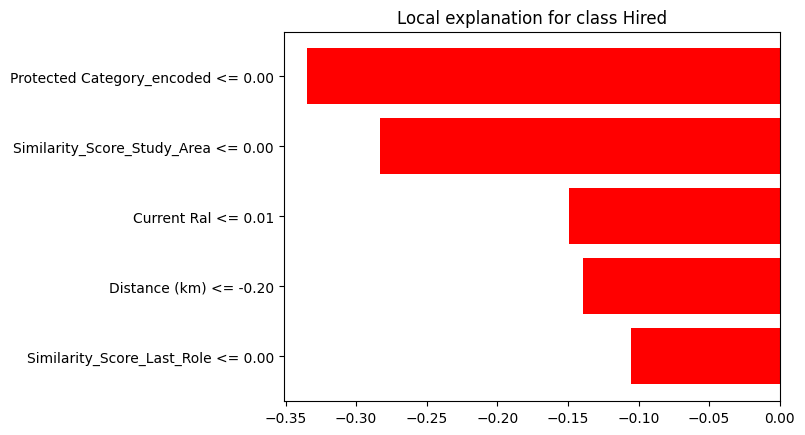

LIME EXPLANATIONS FOR Random forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


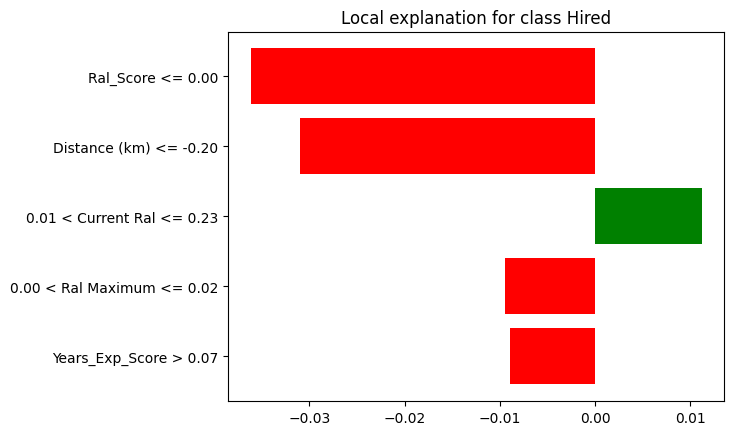

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


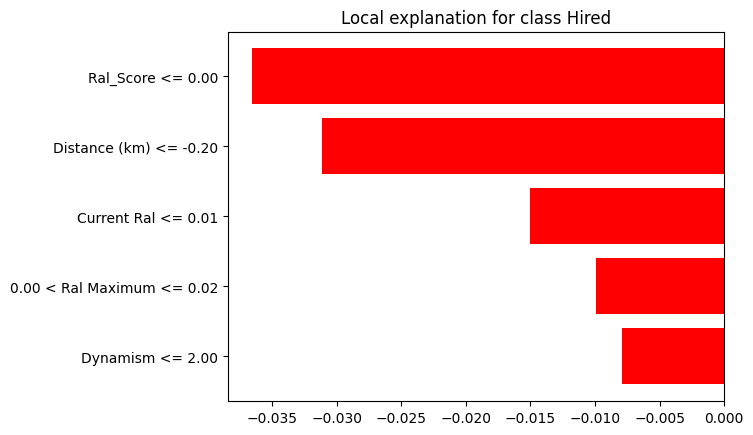

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


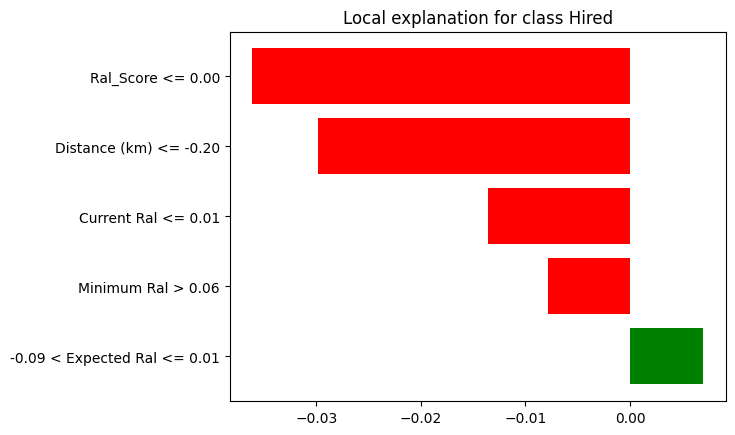

LIME EXPLANATIONS FOR K Nearest Neighbor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


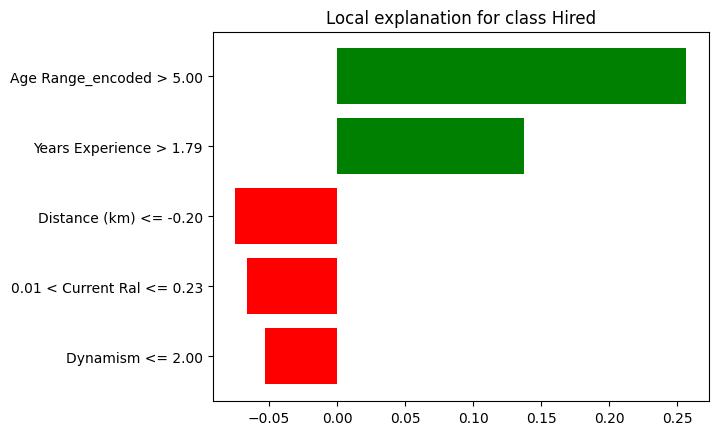

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


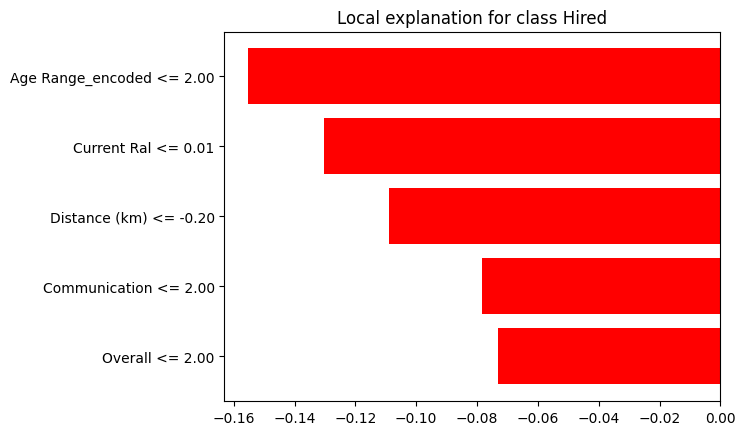

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


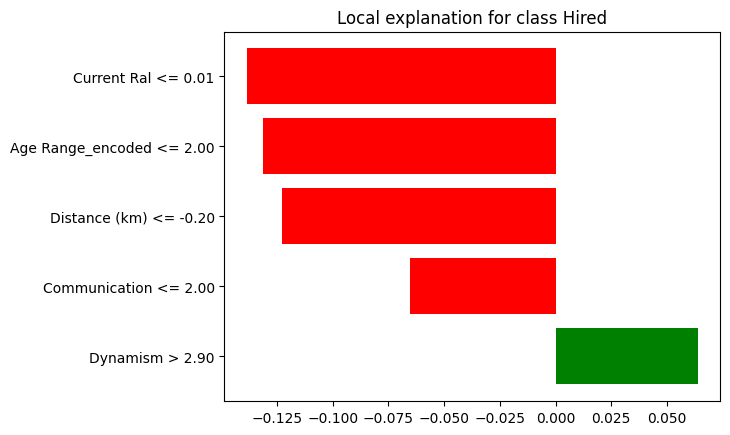

LIME EXPLANATIONS FOR AdaBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


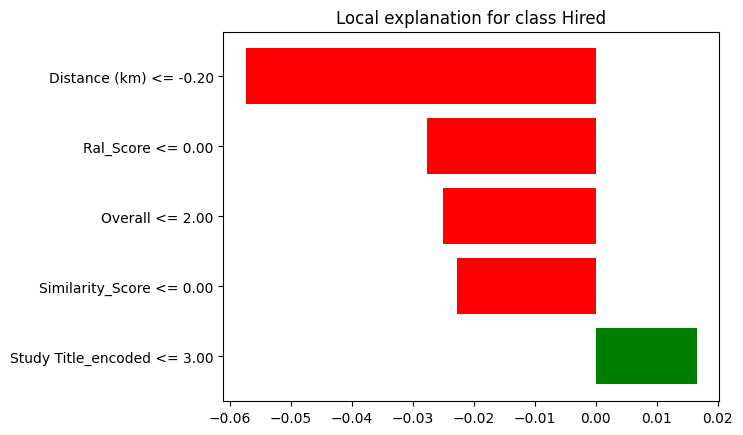

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


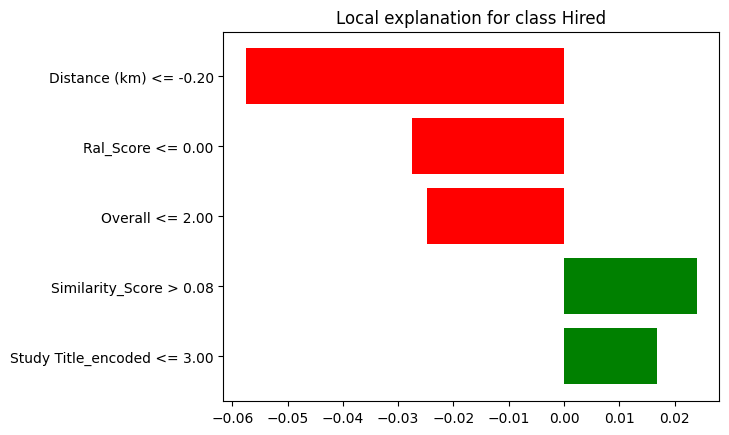

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


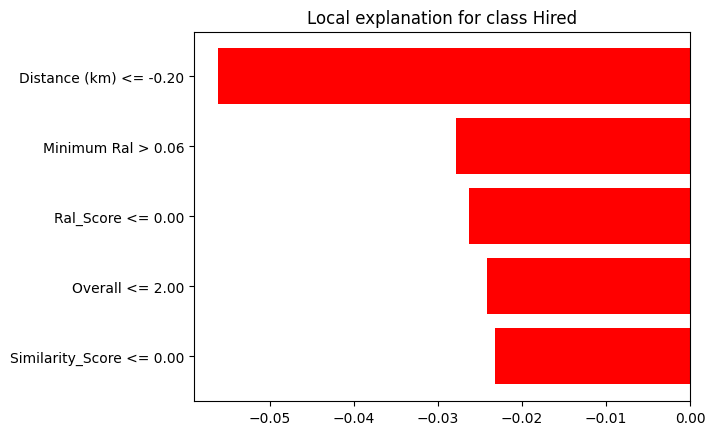

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X_train.columns.tolist(),
    class_names=['Not Hired', 'Hired'])
plt.figure(figsize=(5, 3))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        print(f"LIME EXPLANATIONS FOR {model_name}")
        for i in range(16,19):
            exp_dt = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=5) #Use model directly since we're iterating through values
            fig_dt = exp_dt.as_pyplot_figure()
            plt.show()

###Shap

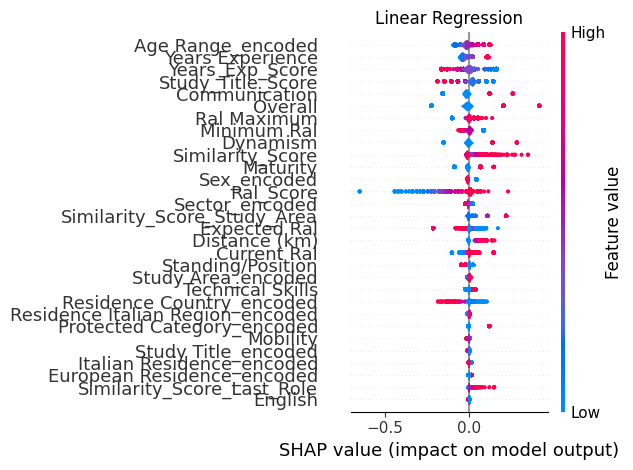

In [ ]:
tot_columns = list(X_test.columns)
summaryPlot(models['Linear Regression'], X_test, tot_columns, plot_type='violin', plot_name='Linear Regression')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
shap shape: (10, 30)


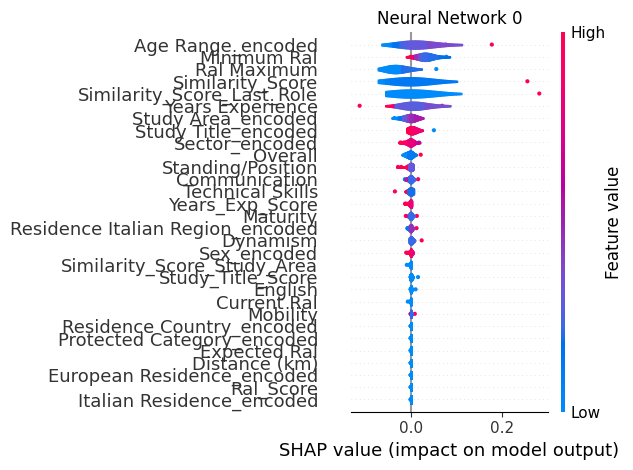

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shap shape: (10, 30)


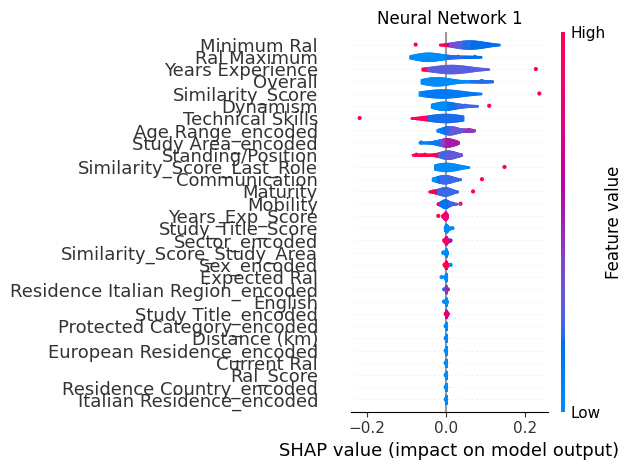

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
655/655 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shap shape: (10, 30)


In [ ]:
tot_columns = list(X_test.columns)
for i,model in enumerate(neural_models):
    summaryPlot(model, X_test, tot_columns, plot_type='violin', plot_name=f'Neural Network {i}')

##Fairness improvement

###Reweighing

In [86]:
X_train_models_reweighted, y_train_models_reweighted = reweight_dataset(X_train_models, y_train_models, sensitive_features)
X_train_reweighted, y_train_reweighted = reweight_dataset(X_train, y_train, sensitive_features)

In [87]:
print("Distribution before reweighting:")
print(X_train[sensitive_features].value_counts())

print("\n\nDistribution after reweighting:")
print(X_train_reweighted[sensitive_features].value_counts())

Distribution before reweighting:
Sex_encoded  Age Range_encoded  Italian Residence_encoded  European Residence_encoded  Protected Category_encoded
1             2                 1                          0                           0                             3609
              3                 1                          0                           0                             2343
              4                 1                          0                           0                             1507
              0                 1                          0                           0                             1418
              5                 1                          0                           0                             1221
                                                                                                                     ... 
0             7                 0                          1                           0                                1

In [93]:
metrics_rew = []
predictions_rew = {}
models_rew = {best_model_params['recall_macro'][m]['name'].rstrip(): best_model_params['recall_macro'][m]['estimator'] for m in best_model_params['recall_macro'].keys()}

for name, model in models_rew.items():
    fit_predict_model(name, model, X_train_models_reweighted, y_train_models_reweighted, X_test, y_test, metrics_rew, predictions_rew)

Fitting Decision Tree...
Fitting Linear Regression...
Fitting Gaussian Naive Bayes...
Fitting Random forest...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...


In [94]:
metrics_rew = pd.DataFrame(metrics_rew)

In [96]:
neural_models_rew = []
neural_predictions_rew = []
histories_rew = []

i = 0
for seed in range(85, 88):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models_rew, histories_rew, X_train_reweighted, y_train_reweighted, X_validation, y_validation, X_test, neural_predictions_rew, best_params_nn, early_stopping=early_stopping)

Fitting model Neural Network 1...
Epoch 1/20
586/586 [==============================] - 6s 7ms/step - loss: 0.1062 - accuracy: 0.7689 - val_loss: 0.4175 - val_accuracy: 0.8702
Epoch 2/20
586/586 [==============================] - 3s 5ms/step - loss: 0.0642 - accuracy: 0.8950 - val_loss: 0.3922 - val_accuracy: 0.8687
Epoch 3/20
586/586 [==============================] - 2s 3ms/step - loss: 0.0517 - accuracy: 0.9178 - val_loss: 0.3053 - val_accuracy: 0.9027
Epoch 4/20
586/586 [==============================] - 2s 3ms/step - loss: 0.0443 - accuracy: 0.9360 - val_loss: 0.1319 - val_accuracy: 0.9641
Epoch 5/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0384 - accuracy: 0.9435 - val_loss: 0.1328 - val_accuracy: 0.9603
Epoch 6/20
586/586 [==============================] - 4s 6ms/step - loss: 0.0362 - accuracy: 0.9486 - val_loss: 0.1635 - val_accuracy: 0.9495
Epoch 7/20
586/586 [==============================] - 3s 5ms/step - loss: 0.0347 - accuracy: 0.9501 - val_loss: 0.

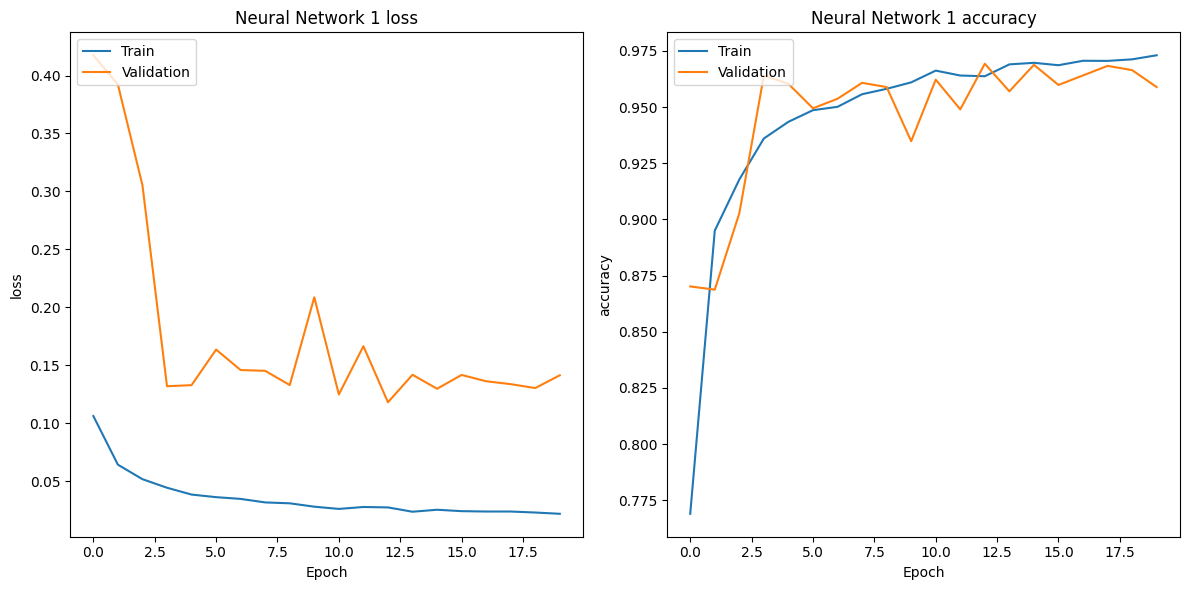

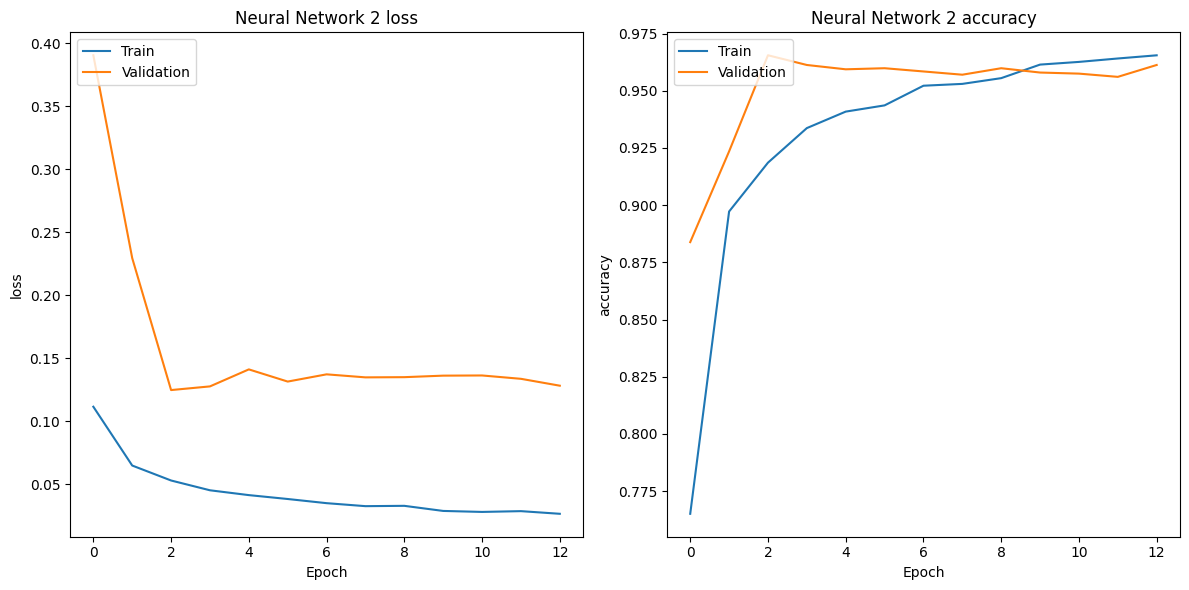

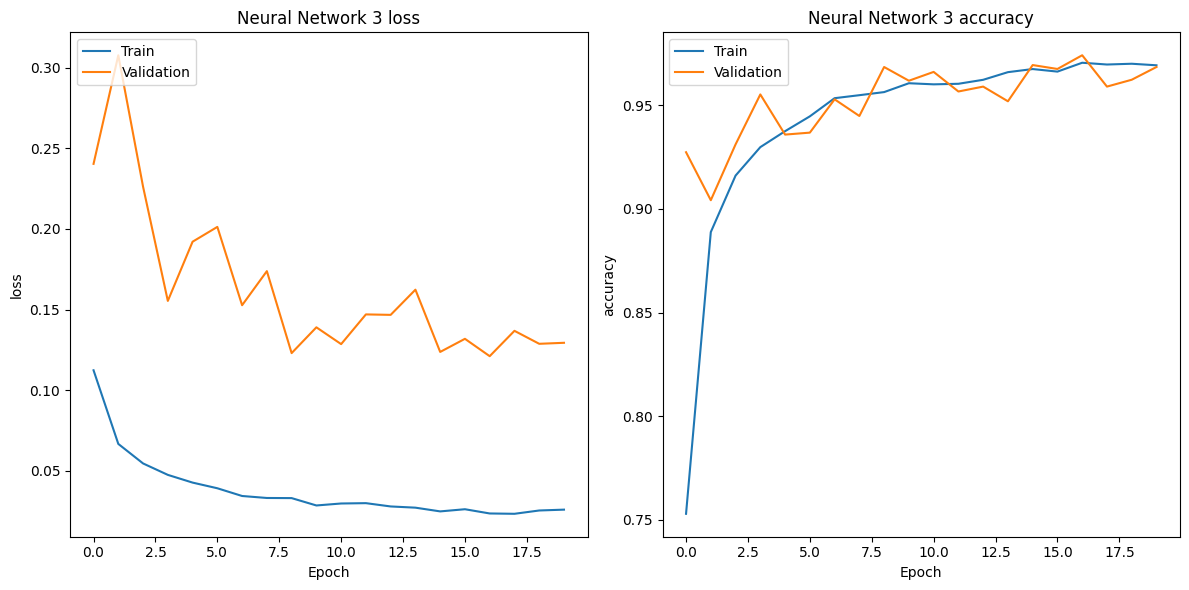

In [99]:
for i, h in enumerate(histories_rew):
  name = f"Neural Network {i+1}"
  plot_val_train(h.history, name)

###NN reweighted export

In [ ]:
for i, model in enumerate(neural_models_rew):
  model.save(f'NNs_rew/neural_network_model_rew{i}')

In [ ]:
!cp -r NNs_rew/ $drive_dir

###NN reweighted import

In [ ]:
neural_models_rew = []

for i in range(0,3):
  model = load_model(f'{drive_dir}NNs_rew/neural_network_model_rew{i}')
  neural_models_rew.append(model)


###NN reweighted predict

In [100]:
neural_predictions_rew = []
for i, model in enumerate(neural_models_rew):
  name = f"Neural Network {i+1}"
  predict_nn(name, model, X_test, neural_predictions_rew)

Predicting with model Neural Network 1...
111/111 [==============================] - 0s 1ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
111/111 [==============================] - 0s 1ms/step
Predictions from model Neural Network 2 stored.


Predicting with model Neural Network 3...
111/111 [==============================] - 0s 1ms/step
Predictions from model Neural Network 3 stored.




In [101]:
nn_metrics_rew = []

for i, y_pred in enumerate(neural_predictions_rew):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics_rew, name)
nn_metrics_rew = pd.DataFrame(nn_metrics_rew)
nn_metrics_rew

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network 1     0.958      0.383   0.626     0.475    0.797
1  Neural Network 2     0.965      0.409   0.355     0.380    0.670
2  Neural Network 3     0.971      0.526   0.467     0.495    0.727

###Performance

In [103]:
combined_metrics_rew = pd.concat([metrics_rew, nn_metrics_rew], ignore_index=True)
combined_metrics_rew.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
1     Linear Regression     0.548      0.060   0.944     0.112    0.860
4     Linear Perceptron     0.621      0.064   0.850     0.120    0.732
2  Gaussian Naive Bayes     0.819      0.105   0.664     0.182    0.834
7      Neural Network 1     0.958      0.383   0.626     0.475    0.797
3         Random forest     0.986      0.938   0.570     0.709    0.948
6              AdaBoost     0.975      0.598   0.570     0.584    0.945
0         Decision Tree     0.982      0.895   0.477     0.622    0.831
9      Neural Network 3     0.971      0.526   0.467     0.495    0.727
8      Neural Network 2     0.965      0.409   0.355     0.380    0.670
5    K Nearest Neighbor     0.842      0.039   0.178     0.064    0.520

In [105]:
for i,model in enumerate(neural_models_rew):
  models_rew[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions_rew):
  predictions_rew[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection after REWEIGHING

###Demographic Parity

In [106]:
getFairnessTab(calculate_demographic_parity,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Sex_encoded
female: 0.6476462196861626
male: 0.43705799151343705
Model unfair to: male


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Age Range_encoded
< 20 years: 0.3842662632375189
20 - 25 years: 0.47959183673469385
26 - 30 years: 0.5446009389671361
31 - 35 years: 0.5233050847457628
36 - 40 years: 0.5110132158590308
40 - 45 years: 0.4129032258064516
> 45 years: 0.3633720930232558
Model unfair to: > 45 years


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Italian Residence_encoded
no: 0.16770186335403728
yes: 0.4937648456057007
Model unfair to: no


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt European Residence_encoded
european: 0.4903621495327103
non-european: 0.10476190476190476
Model unfair to: non

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                                                                  
Linear Regression           male        > 45 years                        no   
Gaussian Naive Bayes                 20 - 25 years                             
Random forest                                                                  
Linear Perceptron           male        < 20 years                             
K Nearest Neighbor                   20 - 25 years                        no   
AdaBoost                                < 20 years                             
Neural Network 1                     26 - 30 years                             
Neural Network 2                        > 45 years                             
Neural Network 3                     20 - 25 years                             

                     European Residence_encoded Protected Category_encoded  
Decision Tree                                                               
Linear Regression                  non-european                         no  
Gaussian Naive Bayes               non-european                             
Random forest                                                               
Linear Perceptron                                                       no  
K Nearest Neighbor                 non-european                        yes  
AdaBoost                                                                    
Neural Network 1                                                            
Neural Network 2                                                            
Neural Network 3

### Equalized Odds

In [107]:
getFairnessTab(calculate_equalized_odds,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Age Range_encoded
Maximum TPR difference: 0.4643 between group 20 - 25 years and group 40 - 45 years
Model unfair to: 40 - 45 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.4857, FPR=0.0016
Group 36 - 40 years: TPR=0.3333, FPR=0.0046
Group < 20 years: TPR=0.5833, FPR=0.0000
Group 31 - 35 years: TPR=0.5217, FPR=0.0000
Group > 45 years: TPR=0.3077, FPR=0.0000
Group 40 - 45 years: TPR=0.2857, FPR=0.0000
Group 20 - 25 years: TPR=0.7500, FPR=0.0078


===============================UNFAIR!===============================
Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Italian Residence_encoded
Maximum TPR difference: 0.5333 between group no and group yes
Model unfair to: yes
TPR and FPR for each group:
Group yes: TPR=0.4667, FPR=0.0015
Group no: TPR=1.0000, FPR=0.0063




There are no positive examples for the group non

Sex_encoded         Age Range_encoded  \
Decision Tree                                40 - 45 years   
Linear Regression           male             36 - 40 years   
Gaussian Naive Bayes              > 45 years 20 - 25 years   
Random forest                                36 - 40 years   
Linear Perceptron                 40 - 45 years < 20 years   
K Nearest Neighbor                > 45 years 20 - 25 years   
AdaBoost                                     40 - 45 years   
Neural Network 1                                > 45 years   
Neural Network 2                                > 45 years   
Neural Network 3                                > 45 years   

                     Italian Residence_encoded European Residence_encoded  \
Decision Tree                              yes               non-european   
Linear Regression                           no               non-european   
Gaussian Naive Bayes                       yes               non-european   
Random forest                                                non-european   
Linear Perceptron                                            non-european   
K Nearest Neighbor                                                          
AdaBoost                                   yes               non-european   
Neural Network 1                                             non-european   
Neural Network 2                                             non-european   
Neural Network 3                                             non-european   

                     Protected Category_encoded  
Decision Tree                               yes  
Linear Regression                                
Gaussian Naive Bayes                        yes  
Random forest                               yes  
Linear Perceptron                           yes  
K Nearest Neighbor                               
AdaBoost                                    yes  
Neural Network 1                            yes  
Neural Network 2                            yes  
Neural Network 3                            yes

###Counterfactual Fairness

In [108]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9986
Most inconsistent group: female 0.0014
Most discriminated group: male -0.0006
Most privileged group: female 0.0014
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: 26 - 30 years 0.0000
Most discriminated group: 26 - 30 years 0.0000
Most privileged group: 26 - 30 years 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(max_depth=6, random_state=42) unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: yes 0.0000
Most discriminated group: yes 0.0000
Most privileged group: yes 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionT

Sex_encoded  \
Decision Tree                                                             
Linear Regression     (male, -0.03117030320204024, female, 0.1136299...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1                                                          
Neural Network 2                                                          
Neural Network 3                                                          

                                                      Age Range_encoded  \
Decision Tree                                                             
Linear Regression     (< 20 years, -0.11136299234910739, > 45 years,...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (< 20 years, -0.15273448568999717, > 45 years,...   
K Nearest Neighbor    (20 - 25 years, -0.03315386795126098, > 45 yea...   
AdaBoost                                                                  
Neural Network 1      (20 - 25 years, -0.006517427033153868, > 45 ye...   
Neural Network 2      (20 - 25 years, -0.005100595069424767, > 45 ye...   
Neural Network 3      (20 - 25 years, -0.0025502975347123833, > 45 y...   

                                              Italian Residence_encoded  \
Decision Tree                                                             
Linear Regression                                                         
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (yes, -0.010201190138849533, no, 0.25672995182...   
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (yes, 0.011334655709832813, no, 0.577217342023...   
Neural Network 2                                                          
Neural Network 3      (yes, 0.004250495891187305, no, 0.706432417115...   

                                             European Residence_encoded  \
Decision Tree                                                             
Linear Regression     (european, -0.000850099178237461, non-european...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (european, -0.00850099178237461, non-european,...   
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (european, 0.0011334655709832814, non-european...   
Neural Network 2                                                          
Neural Network 3      (european, 0.0, non-european, 0.26976480589402...   

                                             Protected Category_encoded  
Decision Tree                                                            
Linear Regression     (no, -0.0028336639274582033, yes, 0.3621422499...  
Gaussian Naive Bayes                                                     
Random forest                                                            
Linear Perceptron     (no, -0.0019835647492207425, yes, 0.2944176820...  
K Nearest Neighbor                                                       
AdaBoost                                                                 
Neural Network 1                                                         
Neural Network 2                                                         
Neural Network 3

##Adversarial Debiasing

In [110]:
epochs = 15
batch_size = 64
threshold = 0.5
logits = True

sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian Residence_encoded', 'Protected Category_encoded']
sensitive_f = [X_train[col] for col in sensitive_features]

In [111]:
def create_Main():
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return model

def create_adversary():
    adv = Sequential([
        Dense(128, input_dim=1, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return adv

In [112]:
def build_batched_data(X, y, sensitive_features, batch_size, names):
    Xb, yb, sens_f, X_adv_b = [], [], [], []
    for i in range(0, len(X), batch_size):
        Xb.append(X[i:i+batch_size])
        yb.append(y[i:i+batch_size])
    for i in range(len(sensitive_features)):
        temp1, temp2 = [], []
        X_adv = X.drop(names[i], axis=1)
        for j in range(0, len(X), batch_size):
            temp1.append(X_adv[j:j+batch_size])
            temp2.append(sensitive_features[i][j:j+batch_size])
        X_adv_b.append(temp1)
        sens_f.append(temp2)
    return Xb, yb, sens_f, X_adv_b

In [113]:
def train_nn(main, adv, X, y, sens_f, X_adv, epochs, adv_n, print_step=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(len(X)):
            X_batch = tf.convert_to_tensor(X[i].values, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y[i].values, dtype=tf.float32)
            sens = tf.convert_to_tensor(sens_f[adv_n][i], dtype=tf.float32)

            with tf.GradientTape(persistent=True) as tape:
                main_preds = main(X_batch, training=True)
                loss_main = loss_fcn_main(y_batch, main_preds)
                adv_preds = adv[adv_n](main_preds, training=True)
                loss_adversary = loss_fcn_adv(sens, adv_preds)
                combined_loss = tf.subtract(loss_main, tf.multiply(0.25, loss_adversary))

            #update main model
            gradients_main = tape.gradient(combined_loss, main.trainable_variables)
            optimizerM.apply_gradients(zip(gradients_main, main.trainable_variables))

            #update adversary model
            gradients_adv = tape.gradient(loss_adversary, adv[adv_n].trainable_variables)
            optimizer_list[adv_n].apply_gradients(zip(gradients_adv, adv[adv_n].trainable_variables))

            del tape

            if i % print_step == 0:
                print(f"Batch {i}/{len(X)} - Main Loss: {loss_main.numpy()}, Adversary Loss: {loss_adversary.numpy()}, Combined Loss: {combined_loss.numpy()}")


In [114]:
#loss functions
loss_fcn_main = BinaryCrossentropy(from_logits=logits)
loss_fcn_adv = BinaryCrossentropy(from_logits=logits)

#optimizers
optimizerM = Adam(learning_rate=0.001)
optimizer_list = [Adam(learning_rate=0.0005) for _ in range(4)]

In [115]:
#main model
np.random.seed(85)
tf.random.set_seed(85)
main_model = create_Main()
main_model.compile(optimizer=optimizerM, loss=loss_fcn_main, metrics=['accuracy'])

In [116]:
#adversary models
adversary_models = [create_adversary() for _ in range(4)]
for adv in adversary_models:
    adv.compile(optimizer=Adam(learning_rate=0.0005), loss=loss_fcn_adv, metrics=['accuracy'])

In [117]:
Xb, yb, sens_f, X_adv_b = build_batched_data(X_train, y_train, sensitive_f, batch_size, sensitive_features)

In [118]:
#initial adversary weights
weights = [adv.get_weights() for adv in adversary_models]

#training main model against each adversary
for j in range(4):
    print(f"\nTraining Main Model against Adversary {j}")
    train_nn(main_model, adversary_models, Xb, yb, sens_f, X_adv_b, epochs, adv_n=j, print_step=60)
    adversary_models[j].set_weights(weights[j])  #adversary weights reset


Training Main Model against Adversary 0
Epoch 1/15
Batch 0/293 - Main Loss: 0.8591963648796082, Adversary Loss: 0.8950889706611633, Combined Loss: 0.6354241371154785
Batch 60/293 - Main Loss: 0.35146060585975647, Adversary Loss: 0.621169924736023, Combined Loss: 0.19616812467575073
Batch 120/293 - Main Loss: 0.3056344985961914, Adversary Loss: 0.5575157999992371, Combined Loss: 0.16625554859638214
Batch 180/293 - Main Loss: 0.22366811335086823, Adversary Loss: 0.5793066620826721, Combined Loss: 0.0788414478302002
Batch 240/293 - Main Loss: 0.23844873905181885, Adversary Loss: 0.5720028281211853, Combined Loss: 0.09544803202152252
Epoch 2/15
Batch 0/293 - Main Loss: 0.1723656803369522, Adversary Loss: 0.68047034740448, Combined Loss: 0.0022480934858322144
Batch 60/293 - Main Loss: 0.21268995106220245, Adversary Loss: 0.5512211918830872, Combined Loss: 0.07488465309143066
Batch 120/293 - Main Loss: 0.27078548073768616, Adversary Loss: 0.5069212913513184, Combined Loss: 0.144055157899856

###Export main

In [127]:
main_model.save(f'Adversarial_Debiasing_mainNNs/neural_network_model_main')

!cp -r Adversarial_Debiasing_mainNNs/ $drive_dir

###Import main

In [ ]:
main_model = load_model(f'{drive_dir}Adversarial_Debiasing_mainNNs/neural_network_model_main')

###Main predictions

In [119]:
main_predictions = []

y_pred = (main_model.predict(X_test) > 0.5).astype("int32").squeeze()
main_predictions.append(y_pred)

111/111 [==============================] - 0s 1ms/step


In [120]:
nn_metrics_main = []

calc_nn_metrics(main_predictions[0], y_test, nn_metrics_main, 'Neural Network Main')

nn_metrics_main = pd.DataFrame(nn_metrics_main)
nn_metrics_main

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network Main     0.967       0.47   0.654     0.547    0.816

###Demographic Parity

In [121]:
models_main = {}
models_main[f"Neural Network Main"] = main_model
predictions_main = {}
predictions_main[f"Neural Network Main"] = main_predictions[0].flatten()

In [122]:
getFairnessTab(calculate_demographic_parity,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Age Range_encoded
< 20 years: 0.0226928895612708
20 - 25 years: 0.02806122448979592
26 - 30 years: 0.03599374021909233
31 - 35 years: 0.08898305084745763
36 - 40 years: 0.05286343612334802
40 - 45 years: 0.08387096774193549
> 45 years: 0.029069767441860465
Model unfair to: < 20 years




Sex_encoded Age Range_encoded Italian Residence_encoded  \
Neural Network Main                    < 20 years                             

                    Protected Category_encoded  
Neural Network Main

### Equalized Odds

In [123]:
getFairnessTab(calculate_equalized_odds,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Age Range_encoded
Maximum TPR difference: 0.6442 between group 20 - 25 years and group > 45 years
Model unfair to: > 45 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.7714, FPR=0.0153
Group 36 - 40 years: TPR=0.3333, FPR=0.0413
Group < 20 years: TPR=0.8333, FPR=0.0077
Group 31 - 35 years: TPR=0.7826, FPR=0.0535
Group > 45 years: TPR=0.2308, FPR=0.0211
Group 40 - 45 years: TPR=0.2857, FPR=0.0743
Group 20 - 25 years: TPR=0.8750, FPR=0.0104


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Protected Category_encoded
Maximum TPR difference: 0.6604 between group no and group yes
Model unfair to: yes
TPR and FPR for each group:
Group no: TPR=0.6604, FPR=0.0230
Group yes: TPR=0.0000, FPR=0.0333




Sex_encoded Age Range_encoded Italian Residence_encoded  \
Neural Network Main                    > 45 years                             

                    Protected Category_encoded  
Neural Network Main                        yes

###Counterfactual Fairness

In [124]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9139
Most inconsistent group: female 0.0057
Most discriminated group: male -0.0011
Most privileged group: female 0.0057
Direction of bias (negative = worse, positive = better)


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 0.7209
Most inconsistent group: > 45 years 0.2165
Most discriminated group: < 20 years -0.0071
Most privileged group: > 45 years 0.2165
Direction of bias (negative = worse, positive = better)


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7b65859d7190> unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 0.6003
Most inco

Sex_encoded  \
Neural Network Main               

                                                     Age Range_encoded  \
Neural Network Main  (< 20 years, -0.007084159818645509, > 45 years...   

                                             Italian Residence_encoded  \
Neural Network Main  (yes, 0.0011334655709832814, no, 0.34825729668...   

                               Protected Category_encoded  
Neural Network Main  (no, 0.0, yes, 0.029186738452819494)

##Explainers

1/1 [==============================] - 0s 140ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

653/653 [==============================] - 1s 1ms/step
shap shape: (10, 30)


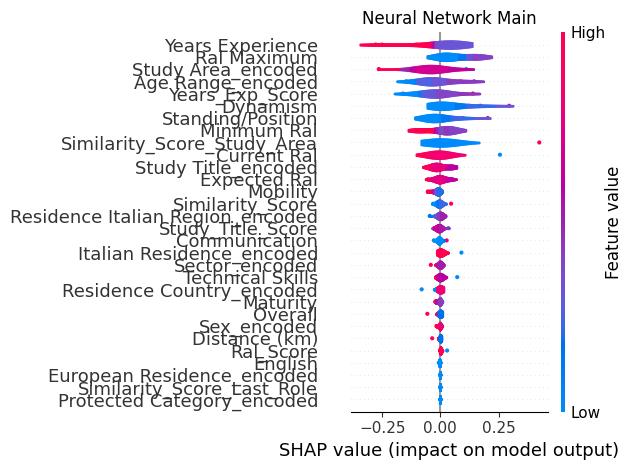

In [126]:
tot_columns = list(X_test.columns)
summaryPlot(main_model, X_test, tot_columns, plot_type='violin', plot_name=f'Neural Network Main')